In [7]:
from prep_custom import get_dataset_settings,create_trace_bucket,remove_features,remove_events,split_data_temporal,replace_missing_cols,prepare_ml_train_test, aggregate_data
from prep_custom import scale_data, one_hot_encode, group_infrequent_features, prepare_dl_train_test, define_binary_outcome_label

from pred_custom import get_evaluation_metrics, train_model, plot_train_history, get_cnn_clf, get_lstm_clf, get_gru_clf, get_dnn_clf

#from typing import Dict
import pandas as pd
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 100)

import numpy as np
import re

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

## Complete Pipeline

In [91]:
#Set to True if dataset is highly unbalanced
balanced=True

outcome_target_list = [
'BPIC17-LoanAccepted',
'BPIC17-PotentialFraud',
'BPIC17-LongRunningCases',
'BPIC13-SupportLevel-1',
'BPIC19-DeletedPO',
'BPICHospital-BillingClosed',
'BPICHospital-CaseReopened',
]

In [3]:
%%time

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from catboost import CatBoostClassifier
from interpret.glassbox import ExplainableBoostingClassifier
import time


clfs = []
clfs.append(LogisticRegression(random_state=0))
clfs.append(RandomForestClassifier()) 
clfs.append(xgb.XGBClassifier()) 
clfs.append(CatBoostClassifier(silent=True)) 

results = pd.DataFrame()

for outcome in outcome_target_list:
    print(outcome)
    eventlog = outcome.split('-')[0]
        
    #Load and label Dataset 
    data, case_id_col, activity_col, timestamp_col, label_col, resource_col, event_categorical_attributes, event_numeric_attributes, case_categorical_attributes, case_numeric_attributes, static_cols, dynamic_cols, cat_cols = get_dataset_settings(eventlog)
    attributes = [event_categorical_attributes, case_categorical_attributes, event_numeric_attributes, case_numeric_attributes]
    data_labeled, drop_events_list, dl_attributes = define_binary_outcome_label(data, attributes, outcome_label=outcome)
    
    #Set Sequence Encoding Setting for ML Classifiers
    sequence_encoding_setting = dict(case_id_col=case_id_col, 
                          activity_col=activity_col,
                          label_col=label_col,
                          case_numeric_attributes=dl_attributes[3],
                          case_categorical_attributes=dl_attributes[1],
                          event_numeric_attributes=dl_attributes[2],
                          event_categorical_attributes=dl_attributes[0],
                            d_event_sequence = False,
                            d_event = True,
                            d_event_categorical = True,
                            d_case_categorical =True,
                            one_hot_case_categorical = True,   
                            d_event_numeric = True,
                            d_case_numeric = True)

    
    #Set max prefix length for benchmark depending on the dataset
    tmp = data[[case_id_col, 'event_nr']].groupby([case_id_col]).max()
    event_length_mean = int(tmp['event_nr'].mean())

    if event_length_mean <= 15:
        event_lengths = list(range(2,event_length_mean,1))
    else:
        event_lengths = list(range(2,15,1))
    
    
    #Run Model Training and Preprocessing for all classifers for each prefix length
    for event_length in event_lengths:
        print("\n ------- PREDICTION OF TRACES WITH LENGTH:", event_length, "-------")
        data_labeled_grouped = group_infrequent_features(data_labeled, max_category_levels = 15)
        trace_bucket, avg_case_progress = create_trace_bucket(data_labeled_grouped, event_length, get_case_progress=True)
        trace_bucket = remove_features(trace_bucket, dl_attributes[0], dl_attributes[1], dl_attributes[2], dl_attributes[3])
        trace_bucket = remove_events(data_labeled, trace_bucket, drop_events_list)

        train_raw, test_raw = split_data_temporal(data=trace_bucket, train_ratio=0.8)

        #ML Section
        ## Preprocessing
        train = aggregate_data(train_raw, 
                               **sequence_encoding_setting)

        test = aggregate_data(test_raw, 
                              **sequence_encoding_setting)

        train, test = replace_missing_cols(train, test)
        
        #Regex required for XGB and BPIC19
        regex = re.compile(r"\[|\]|<", re.IGNORECASE)
        train.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in train.columns.values]
        test.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in test.columns.values]
        
        X_train_ml, y_train_ml, X_test_ml, y_test_ml = prepare_ml_train_test(train,test, balanced)

        ## ML Model Training and Evaluation
        for clf in clfs:
            try:
                print("\n---", str(clf)[:7], "---", sep="")

                start_time = time.time()
                clf.fit(X_train_ml, y_train_ml)
                train_time = time.time() - start_time
                y_pred, auc, acc, f1, mcc, sensitivity, specificity, pred_time = get_evaluation_metrics(clf, X_test_ml, y_test_ml, X_train_ml, y_train_ml, exec_time=True)

                results = results.append(pd.DataFrame({
                                                  'Outcome':[outcome],
                                                  'Model':str(clf)[:7],
                                                  'Event_Length': [event_length], 
                                                  'Acc':[acc], 'Auc':[auc], 'F1':[f1],'Mcc':[mcc],
                                                  'Sensitivity':[sensitivity],'Specificity':[specificity],
                                                  'Train_Time':[train_time],
                                                  'Prediction_Time':[pred_time],
                                                  'Avg_Case_Progress':[avg_case_progress]}))
            except Exception as e:
                print(e)

        
        
        
        print("\n--- EBM ---")
        clf_ebm = ExplainableBoostingClassifier()
        start_time = time.time()
        clf_ebm.fit(X_train_ml, y_train_ml)
        train_time = time.time() - start_time
        y_pred, auc, acc, f1, mcc, sensitivity, specificity, pred_time = get_evaluation_metrics(clf_ebm, X_test_ml, y_test_ml, X_train_ml, y_train_ml, exec_time=True)

        results = results.append(pd.DataFrame({
                                  'Outcome':[outcome],
                                  'Model':'EBM',
                                  'Event_Length': [event_length], 
                                  'Acc':[acc], 'Auc':[auc], 'F1':[f1],'Mcc':[mcc],
                                  'Sensitivity':[sensitivity],'Specificity':[specificity],
                                  'Train_Time':[train_time],
                                  'Prediction_Time':[pred_time],
                                  'Avg_Case_Progress':[avg_case_progress]}))

       """   
        #DL Section
        ## DNN Preprocessing
        #from sklearn.preprocessing import StandardScaler
        #x_train_numeric = X_train_ml.copy()
        #y_train_numeric = y_train_ml[label_col].astype(np.int64)
        #x_test_numeric = X_test_ml.copy()
        #y_test_numeric = y_test_ml[label_col].astype(np.int64)

        #num_cols = x_train_numeric.columns.values
        #for col in num_cols: 
        #    scale = StandardScaler().fit(x_train_numeric[[col]])   
        #    x_train_numeric[col] = scale.transform(x_train_numeric[[col]])
        #    x_test_numeric[col] = scale.transform(x_test_numeric[[col]])#
        """


        ## RNN Preprocessing
        train, test = scale_data(train_raw, test_raw)
        train = one_hot_encode(train)
        test = one_hot_encode(test)
        train, test = replace_missing_cols(train, test)

        X_train_dl, y_train_dl, feature_names = prepare_dl_train_test(train, event_length)
        X_test_dl, y_test_dl, feature_names = prepare_dl_train_test(test, event_length)


         ## DL Model Training and Evaluation
        
        try:
       
            print("\n--- CNN ---")
            model_structure = get_cnn_clf(X_train_dl)

            start_time = time.time()
            model, hist = train_model(model_structure, X_train_dl, X_test_dl, y_train_dl, y_test_dl, 
                                verbose=True, weighted=True, epochs=20, batch_size=64)
            train_time = time.time() - start_time

            y_pred, auc, acc, f1, mcc, sensitivity, specificity,  pred_time = get_evaluation_metrics(model, X_test_dl, y_test_dl, X_train_dl, y_train_dl, exec_time=True)

            results = results.append(pd.DataFrame({
                              'Outcome':[outcome],
                              'Model':'CNN',
                              'Event_Length': [event_length], 
                              'Acc':[acc], 'Auc':[auc], 'F1':[f1],'Mcc':[mcc],
                              'Sensitivity':[sensitivity],'Specificity':[specificity],
                              'Train_Time':[train_time],
                              'Prediction_Time':[pred_time],
                              'Avg_Case_Progress':[avg_case_progress]}))

        except Exception as e:
            print('CNN ERROR', e)
            
        try:    
            print("\n--- GRU ---")
            model_structure = get_gru_clf(X_train_dl)

            start_time = time.time()
            model, hist = train_model(model_structure, X_train_dl, X_test_dl, y_train_dl, y_test_dl, 
                                verbose=True, weighted=True, epochs=20, batch_size=64)
            train_time = time.time() - start_time

            y_pred, auc, acc, f1, mcc, sensitivity, specificity, pred_time = get_evaluation_metrics(model, X_test_dl, y_test_dl, X_train_dl, y_train_dl, exec_time=True)

            results = results.append(pd.DataFrame({
                                      'Outcome':[outcome],
                                      'Model':'GRU',
                                      'Event_Length': [event_length], 
                                      'Acc':[acc], 'Auc':[auc], 'F1':[f1], 'Mcc':[mcc],
                                      'Sensitivity':[sensitivity],'Specificity':[specificity],
                                      'Train_Time':[train_time],
                                      'Prediction_Time':[pred_time],
                                      'Avg_Case_Progress':[avg_case_progress]}))

            
            print("\n--- LSTM ---")
            model_structure = get_lstm_clf(X_train_dl)

            start_time = time.time()
            model, hist = train_model(model_structure, X_train_dl, X_test_dl, y_train_dl, y_test_dl, 
                                verbose=True, weighted=True, epochs=20, batch_size=64)
            train_time = time.time() - start_time

            y_pred, auc, acc, f1, mcc, sensitivity, specificity, pred_time = get_evaluation_metrics(model, X_test_dl, y_test_dl, X_train_dl, y_train_dl, exec_time=True)

            results = results.append(pd.DataFrame({
                                      'Outcome':[outcome],
                                      'Model':'LSTM',
                                      'Event_Length': [event_length], 
                                      'Acc':[acc], 'Auc':[auc], 'F1':[f1], 'Mcc':[mcc],
                                      'Sensitivity':[sensitivity],'Specificity':[specificity],
                                      'Train_Time':[train_time],
                                      'Prediction_Time':[pred_time],
                                      'Avg_Case_Progress':[avg_case_progress]}))

        except Exception as e:
            print('RNN ERROR', e)
            



        """
        print("\n--- DNN ---")
        model_structure = get_dnn_clf(x_train_numeric)

        model, hist = train_model(model_structure, x_train_numeric, x_test_numeric, y_train_numeric, y_test_numeric, 
                            verbose=True, weighted=False, epochs=20, batch_size=64)

        y_pred, auc, acc, f1 = get_evaluation_metrics(model, x_test_numeric, y_test_numeric, x_train_numeric, y_train_numeric)

        results = results.append(pd.DataFrame({'Model':'DNN',
                                      'Event_Length': [event_length], 
                                      'Acc':[acc], 'Auc':[auc], 'F1':[f1]}))
        """
    
        
        results.reset_index(drop=True, inplace=True)
        results.to_csv("Benchmark_Final_Test_v2.csv", index=False)

results.reset_index(drop=True, inplace=True)
#results



BPIC17-LoanAccepted
Categoric Event Attributes: 6 ['concept:name', 'org:resource', 'Action', 'lifecycle:transition', 'Accepted', 'Selected'] 

Numeric Event Attributes: 13 ['CreditScore', 'FirstWithdrawalAmount', 'MonthlyCost', 'NumberOfTerms', 'OfferedAmount', 'timesincelastevent', 'timesincecasestart', 'timesincemidnight', 'event_nr', 'month', 'weekday', 'hour', 'open_cases'] 

Categoric Case Attributes: 3 ['case:ApplicationType', 'case:LoanGoal', 'EventOrigin'] 

Numeric Case Attributes: 1 ['case:RequestedAmount'] 

Dataset Shape (1202267, 26)
Assigning class labels...
Set labels to 1 for Outcome: O_Accepted
label
0    18621
1    12792
Name: case:concept:name, dtype: int64

 ------- PREDICTION OF TRACES WITH LENGTH: 2 -------
Binning and Grouping infrequent factor levels to: Other_infrequent
Making predictions after 2 completed events
Making predictions at time after cases have started on average:  0.0 hours/ 0.0 days
Making predictions at time before cases have finished on average:

Confusion Matrix:
[[2586 1178]
 [1412 1107]]
              precision    recall  f1-score   support

           0       0.65      0.69      0.67      3764
           1       0.48      0.44      0.46      2519

    accuracy                           0.59      6283
   macro avg       0.57      0.56      0.56      6283
weighted avg       0.58      0.59      0.58      6283

Accuracy: 0.588 (Train: 0.702 )
AUC: 0.59
F1: 0.564
MCC: 0.129
Sensitivity :  0.687
Specificity :  0.439

--- EBM ---
Confusion Matrix:
[[2318 1446]
 [1225 1294]]
              precision    recall  f1-score   support

           0       0.65      0.62      0.63      3764
           1       0.47      0.51      0.49      2519

    accuracy                           0.57      6283
   macro avg       0.56      0.56      0.56      6283
weighted avg       0.58      0.57      0.58      6283

Accuracy: 0.575 (Train: 0.605 )
AUC: 0.596
F1: 0.563
MCC: 0.128
Sensitivity :  0.616
Specificity :  0.514
[] []

--- CNN ---
Model: "CNN"


393/393 [==============================] - 52s 117ms/step - loss: 0.6925 - auc: 0.4900 - acc: 0.5221 - val_loss: 0.6935 - val_auc: 0.5354 - val_acc: 0.4697
Epoch 2/20
393/393 [==============================] - 41s 104ms/step - loss: 0.6922 - auc: 0.5189 - acc: 0.5308 - val_loss: 0.6932 - val_auc: 0.5542 - val_acc: 0.4996
Epoch 3/20
393/393 [==============================] - 45s 114ms/step - loss: 0.6918 - auc: 0.5482 - acc: 0.5582 - val_loss: 0.6929 - val_auc: 0.5630 - val_acc: 0.5456
Epoch 4/20
393/393 [==============================] - 45s 114ms/step - loss: 0.6914 - auc: 0.5704 - acc: 0.5748 - val_loss: 0.6926 - val_auc: 0.5669 - val_acc: 0.5757
Confusion Matrix:
[[2509 1255]
 [1411 1108]]
              precision    recall  f1-score   support

           0       0.64      0.67      0.65      3764
           1       0.47      0.44      0.45      2519

    accuracy                           0.58      6283
   macro avg       0.55      0.55      0.55      6283
weighted avg       0.57   

Confusion Matrix:
[[2656 1108]
 [1488 1031]]
              precision    recall  f1-score   support

           0       0.64      0.71      0.67      3764
           1       0.48      0.41      0.44      2519

    accuracy                           0.59      6283
   macro avg       0.56      0.56      0.56      6283
weighted avg       0.58      0.59      0.58      6283

Accuracy: 0.587 (Train: 0.588 )
AUC: 0.589
F1: 0.557
MCC: 0.119
Sensitivity :  0.706
Specificity :  0.409

--- GRU ---
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_6 (GRU)                  (None, 4, 480)            774720    
_________________________________________________________________
gru_7 (GRU)                  (None, 4, 448)            1249920   
_________________________________________________________________
gru_8 (GRU)                  (None, 96)                157248    
_________________________

Epoch 19/20
393/393 [==============================] - 62s 157ms/step - loss: 0.6726 - auc: 0.6004 - acc: 0.6029 - val_loss: 0.6817 - val_auc: 0.5695 - val_acc: 0.5833
Epoch 20/20
393/393 [==============================] - 68s 174ms/step - loss: 0.6729 - auc: 0.5993 - acc: 0.6032 - val_loss: 0.6811 - val_auc: 0.5710 - val_acc: 0.5833
Confusion Matrix:
[[2625 1139]
 [1479 1040]]
              precision    recall  f1-score   support

           0       0.64      0.70      0.67      3764
           1       0.48      0.41      0.44      2519

    accuracy                           0.58      6283
   macro avg       0.56      0.56      0.56      6283
weighted avg       0.57      0.58      0.58      6283

Accuracy: 0.583 (Train: 0.601 )
AUC: 0.57
F1: 0.555
MCC: 0.114
Sensitivity :  0.697
Specificity :  0.413

 ------- PREDICTION OF TRACES WITH LENGTH: 5 -------
Binning and Grouping infrequent factor levels to: Other_infrequent
Making predictions after 5 completed events
Making predictions at 

AUC: 0.577
F1: 0.554
MCC: 0.111
Sensitivity :  0.694
Specificity :  0.414

 ------- PREDICTION OF TRACES WITH LENGTH: 6 -------
Binning and Grouping infrequent factor levels to: Other_infrequent
Making predictions after 6 completed events
Making predictions at time after cases have started on average:  2.4 hours/ 0.1 days
Making predictions at time before cases have finished on average:  474.3 hours/ 19.8 days

 Shape: (188478, 27)
Features removed:  3

 Events included:
['A_Create Application' 'A_Submitted' 'W_Handle leads'
 'W_Complete application' 'A_Concept' 'A_Accepted' 'O_Create Offer'
 'W_Assess potential fraud']
[] []
Undersampling Train Data
(20546, 64) (6283, 64)

---Logisti---
Confusion Matrix:
[[3548  216]
 [1730  789]]
              precision    recall  f1-score   support

           0       0.67      0.94      0.78      3764
           1       0.79      0.31      0.45      2519

    accuracy                           0.69      6283
   macro avg       0.73      0.63      0

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_12 (GRU)                 (None, 6, 480)            786240    
_________________________________________________________________
gru_13 (GRU)                 (None, 6, 448)            1249920   
_________________________________________________________________
gru_14 (GRU)                 (None, 96)                157248    
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 97        
Total params: 2,193,505
Trainable params: 2,193,505
Non-trainable params: 0
_________________________________________________________________
None
{0: 0.8457292858585179, 1: 1.2231091209967877}
Epoch 1/20
393/393 [==============================] - 90s 216ms/step - loss: 0.6801 - auc: 0.5917 - acc: 0.6194 - val_loss: 0.6591 - val_auc: 0.5986 - val_acc: 0.6403
Epoch 2/20
393/393 [===

[] []
Undersampling Train Data
(20546, 66) (6283, 66)

---Logisti---
Confusion Matrix:
[[3646  118]
 [1818  701]]
              precision    recall  f1-score   support

           0       0.67      0.97      0.79      3764
           1       0.86      0.28      0.42      2519

    accuracy                           0.69      6283
   macro avg       0.76      0.62      0.61      6283
weighted avg       0.74      0.69      0.64      6283

Accuracy: 0.692 (Train: 0.615 )
AUC: 0.697
F1: 0.605
MCC: 0.359
Sensitivity :  0.969
Specificity :  0.278

---RandomF---
Confusion Matrix:
[[2724 1040]
 [1031 1488]]
              precision    recall  f1-score   support

           0       0.73      0.72      0.72      3764
           1       0.59      0.59      0.59      2519

    accuracy                           0.67      6283
   macro avg       0.66      0.66      0.66      6283
weighted avg       0.67      0.67      0.67      6283

Accuracy: 0.67 (Train: 1.0 )
AUC: 0.744
F1: 0.657
MCC: 0.314
Sensi

Epoch 2/20
393/393 [==============================] - 111s 282ms/step - loss: 0.5968 - auc: 0.7430 - acc: 0.7171 - val_loss: 0.5680 - val_auc: 0.7475 - val_acc: 0.7084
Epoch 3/20
393/393 [==============================] - 112s 286ms/step - loss: 0.5706 - auc: 0.7541 - acc: 0.7114 - val_loss: 0.5581 - val_auc: 0.7495 - val_acc: 0.7091
Epoch 4/20
393/393 [==============================] - 118s 299ms/step - loss: 0.5648 - auc: 0.7566 - acc: 0.7036 - val_loss: 0.5563 - val_auc: 0.7499 - val_acc: 0.7095
Epoch 5/20
393/393 [==============================] - 114s 290ms/step - loss: 0.5633 - auc: 0.7576 - acc: 0.7007 - val_loss: 0.5557 - val_auc: 0.7507 - val_acc: 0.7094
Epoch 6/20
393/393 [==============================] - 116s 296ms/step - loss: 0.5627 - auc: 0.7581 - acc: 0.6997 - val_loss: 0.5553 - val_auc: 0.7512 - val_acc: 0.7110
Epoch 7/20
393/393 [==============================] - 113s 287ms/step - loss: 0.5623 - auc: 0.7588 - acc: 0.7005 - val_loss: 0.5549 - val_auc: 0.7514 - val_acc:

Confusion Matrix:
[[3072  692]
 [1094 1425]]
              precision    recall  f1-score   support

           0       0.74      0.82      0.77      3764
           1       0.67      0.57      0.61      2519

    accuracy                           0.72      6283
   macro avg       0.71      0.69      0.69      6283
weighted avg       0.71      0.72      0.71      6283

Accuracy: 0.716 (Train: 0.828 )
AUC: 0.79
F1: 0.695
MCC: 0.396
Sensitivity :  0.816
Specificity :  0.566

---<catboo---
Confusion Matrix:
[[3159  605]
 [1121 1398]]
              precision    recall  f1-score   support

           0       0.74      0.84      0.79      3764
           1       0.70      0.55      0.62      2519

    accuracy                           0.73      6283
   macro avg       0.72      0.70      0.70      6283
weighted avg       0.72      0.73      0.72      6283

Accuracy: 0.725 (Train: 0.787 )
AUC: 0.79
F1: 0.702
MCC: 0.415
Sensitivity :  0.839
Specificity :  0.555

--- EBM ---
Confusion Matrix:


Epoch 9/20
393/393 [==============================] - 108s 276ms/step - loss: 0.5370 - auc: 0.7885 - acc: 0.7298 - val_loss: 0.5292 - val_auc: 0.7823 - val_acc: 0.7337
Epoch 10/20
393/393 [==============================] - 108s 276ms/step - loss: 0.5365 - auc: 0.7890 - acc: 0.7299 - val_loss: 0.5287 - val_auc: 0.7826 - val_acc: 0.7337
Epoch 11/20
393/393 [==============================] - 110s 280ms/step - loss: 0.5360 - auc: 0.7894 - acc: 0.7304 - val_loss: 0.5282 - val_auc: 0.7829 - val_acc: 0.7340
Epoch 12/20
393/393 [==============================] - 111s 283ms/step - loss: 0.5355 - auc: 0.7898 - acc: 0.7302 - val_loss: 0.5277 - val_auc: 0.7830 - val_acc: 0.7342
Epoch 13/20
393/393 [==============================] - 108s 276ms/step - loss: 0.5350 - auc: 0.7902 - acc: 0.7300 - val_loss: 0.5272 - val_auc: 0.7833 - val_acc: 0.7344
Epoch 14/20
393/393 [==============================] - 111s 283ms/step - loss: 0.5345 - auc: 0.7905 - acc: 0.7300 - val_loss: 0.5267 - val_auc: 0.7836 - val

Confusion Matrix:
[[3027  737]
 [ 750 1769]]
              precision    recall  f1-score   support

           0       0.80      0.80      0.80      3764
           1       0.71      0.70      0.70      2519

    accuracy                           0.76      6283
   macro avg       0.75      0.75      0.75      6283
weighted avg       0.76      0.76      0.76      6283

Accuracy: 0.763 (Train: 1.0 )
AUC: 0.86
F1: 0.753
MCC: 0.507
Sensitivity :  0.804
Specificity :  0.702

---XGBClas---
[16:25:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Confusion Matrix:
[[3238  526]
 [ 864 1655]]
              precision    recall  f1-score   support

           0       0.79      0.86      0.82      3764
           1       0.76      0.66      0.70   

393/393 [==============================] - 130s 321ms/step - loss: 0.6279 - auc: 0.7218 - acc: 0.6928 - val_loss: 0.5142 - val_auc: 0.8370 - val_acc: 0.7708
Epoch 2/20
393/393 [==============================] - 127s 324ms/step - loss: 0.5107 - auc: 0.8403 - acc: 0.7839 - val_loss: 0.4892 - val_auc: 0.8448 - val_acc: 0.7789
Epoch 3/20
393/393 [==============================] - 126s 321ms/step - loss: 0.4930 - auc: 0.8467 - acc: 0.7870 - val_loss: 0.4828 - val_auc: 0.8469 - val_acc: 0.7792
Epoch 4/20
393/393 [==============================] - 127s 324ms/step - loss: 0.4875 - auc: 0.8493 - acc: 0.7863 - val_loss: 0.4786 - val_auc: 0.8491 - val_acc: 0.7783
Epoch 5/20
393/393 [==============================] - 131s 333ms/step - loss: 0.4837 - auc: 0.8513 - acc: 0.7856 - val_loss: 0.4750 - val_auc: 0.8508 - val_acc: 0.7792
Epoch 6/20
393/393 [==============================] - 142s 361ms/step - loss: 0.4803 - auc: 0.8532 - acc: 0.7863 - val_loss: 0.4716 - val_auc: 0.8523 - val_acc: 0.7792
Epo

Making predictions after 10 completed events
Making predictions at time after cases have started on average:  26.7 hours/ 1.112 days
Making predictions at time before cases have finished on average:  450.0 hours/ 18.7 days

 Shape: (313787, 27)
Features removed:  3

 Events included:
['A_Create Application' 'A_Submitted' 'W_Handle leads'
 'W_Complete application' 'A_Concept' 'A_Accepted' 'O_Create Offer'
 'O_Created' 'O_Sent (mail and online)' 'W_Call after offers'
 'O_Sent (online only)' 'W_Assess potential fraud' 'A_Cancelled'
 'W_Shortened completion ' 'A_Denied']
[] []
Undersampling Train Data
(20546, 71) (6283, 71)

---Logisti---
Confusion Matrix:
[[3572  192]
 [1006 1513]]
              precision    recall  f1-score   support

           0       0.78      0.95      0.86      3764
           1       0.89      0.60      0.72      2519

    accuracy                           0.81      6283
   macro avg       0.83      0.77      0.79      6283
weighted avg       0.82      0.81      0

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_24 (GRU)                 (None, 10, 480)           796320    
_________________________________________________________________
gru_25 (GRU)                 (None, 10, 448)           1249920   
_________________________________________________________________
gru_26 (GRU)                 (None, 96)                157248    
_________________________________________________________________
dense_70 (Dense)             (None, 1)                 97        
Total params: 2,203,585
Trainable params: 2,203,585
Non-trainable params: 0
_________________________________________________________________
None
{0: 0.8457292858585179, 1: 1.2231091209967877}
Epoch 1/20
393/393 [==============================] - 169s 416ms/step - loss: 0.5951 - auc: 0.7698 - acc: 0.7295 - val_loss: 0.4527 - val_auc: 0.8832 - val_acc: 0.8081
Epoch 2/20
393/393 [=

393/393 [==============================] - 8s 19ms/step - loss: 0.3521 - auc: 0.9211 - acc: 0.8469 - val_loss: 0.3275 - val_auc: 0.9302 - val_acc: 0.8510
Epoch 4/20
393/393 [==============================] - 7s 19ms/step - loss: 0.3465 - auc: 0.9229 - acc: 0.8519 - val_loss: 0.3206 - val_auc: 0.9301 - val_acc: 0.8590
Epoch 5/20
393/393 [==============================] - 8s 20ms/step - loss: 0.3424 - auc: 0.9250 - acc: 0.8532 - val_loss: 0.3194 - val_auc: 0.9318 - val_acc: 0.8587
Epoch 6/20
393/393 [==============================] - 8s 21ms/step - loss: 0.3368 - auc: 0.9276 - acc: 0.8560 - val_loss: 0.3177 - val_auc: 0.9329 - val_acc: 0.8609
Epoch 7/20
393/393 [==============================] - 7s 19ms/step - loss: 0.3359 - auc: 0.9274 - acc: 0.8577 - val_loss: 0.3134 - val_auc: 0.9329 - val_acc: 0.8625
Epoch 8/20
393/393 [==============================] - 7s 19ms/step - loss: 0.3302 - auc: 0.9301 - acc: 0.8597 - val_loss: 0.3130 - val_auc: 0.9332 - val_acc: 0.8631
Epoch 9/20
393/393 [=

393/393 [==============================] - 237s 593ms/step - loss: 0.6822 - auc: 0.6470 - acc: 0.6251 - val_loss: 0.6403 - val_auc: 0.7741 - val_acc: 0.7578
Epoch 2/20
393/393 [==============================] - 269s 685ms/step - loss: 0.6170 - auc: 0.7948 - acc: 0.7674 - val_loss: 0.5424 - val_auc: 0.8621 - val_acc: 0.7878
Epoch 3/20
393/393 [==============================] - 247s 628ms/step - loss: 0.5271 - auc: 0.8496 - acc: 0.7939 - val_loss: 0.4657 - val_auc: 0.8870 - val_acc: 0.8111
Epoch 4/20
393/393 [==============================] - 250s 636ms/step - loss: 0.4775 - auc: 0.8629 - acc: 0.8002 - val_loss: 0.4378 - val_auc: 0.8960 - val_acc: 0.8219
Epoch 5/20
393/393 [==============================] - 248s 631ms/step - loss: 0.4626 - auc: 0.8679 - acc: 0.8043 - val_loss: 0.4253 - val_auc: 0.9012 - val_acc: 0.8273
Epoch 6/20
393/393 [==============================] - 253s 644ms/step - loss: 0.4552 - auc: 0.8726 - acc: 0.8065 - val_loss: 0.4186 - val_auc: 0.9052 - val_acc: 0.8287
Epo

393/393 [==============================] - 10s 22ms/step - loss: 0.4976 - auc: 0.8230 - acc: 0.7477 - val_loss: 0.3091 - val_auc: 0.9424 - val_acc: 0.8642
Epoch 2/20
393/393 [==============================] - 8s 21ms/step - loss: 0.3176 - auc: 0.9365 - acc: 0.8650 - val_loss: 0.2893 - val_auc: 0.9457 - val_acc: 0.8755
Epoch 3/20
393/393 [==============================] - 8s 21ms/step - loss: 0.3083 - auc: 0.9396 - acc: 0.8724 - val_loss: 0.2846 - val_auc: 0.9469 - val_acc: 0.8811
Epoch 4/20
393/393 [==============================] - 8s 21ms/step - loss: 0.3041 - auc: 0.9413 - acc: 0.8783 - val_loss: 0.2794 - val_auc: 0.9483 - val_acc: 0.8845
Epoch 5/20
393/393 [==============================] - 8s 21ms/step - loss: 0.2976 - auc: 0.9436 - acc: 0.8814 - val_loss: 0.2786 - val_auc: 0.9479 - val_acc: 0.8829
Epoch 6/20
393/393 [==============================] - 9s 22ms/step - loss: 0.2931 - auc: 0.9451 - acc: 0.8834 - val_loss: 0.2787 - val_auc: 0.9477 - val_acc: 0.8837
Epoch 7/20
393/393 [

Epoch 2/20
393/393 [==============================] - 254s 646ms/step - loss: 0.5693 - auc: 0.8268 - acc: 0.7978 - val_loss: 0.4615 - val_auc: 0.8997 - val_acc: 0.8252
Epoch 3/20
393/393 [==============================] - 256s 652ms/step - loss: 0.4604 - auc: 0.8825 - acc: 0.8251 - val_loss: 0.4053 - val_auc: 0.9152 - val_acc: 0.8385
Epoch 4/20
393/393 [==============================] - 254s 647ms/step - loss: 0.4251 - auc: 0.8930 - acc: 0.8298 - val_loss: 0.3887 - val_auc: 0.9214 - val_acc: 0.8451
Epoch 5/20
393/393 [==============================] - 257s 655ms/step - loss: 0.4138 - auc: 0.8980 - acc: 0.8263 - val_loss: 0.3797 - val_auc: 0.9247 - val_acc: 0.8477
Epoch 6/20
393/393 [==============================] - 256s 651ms/step - loss: 0.4046 - auc: 0.9039 - acc: 0.8351 - val_loss: 0.3694 - val_auc: 0.9266 - val_acc: 0.8475
Epoch 7/20
393/393 [==============================] - 261s 664ms/step - loss: 0.3934 - auc: 0.9095 - acc: 0.8394 - val_loss: 0.3655 - val_auc: 0.9272 - val_acc:

393/393 [==============================] - 10s 22ms/step - loss: 0.4469 - auc: 0.8685 - acc: 0.7944 - val_loss: 0.2928 - val_auc: 0.9468 - val_acc: 0.8856
Epoch 2/20
393/393 [==============================] - 8s 20ms/step - loss: 0.3051 - auc: 0.9416 - acc: 0.8785 - val_loss: 0.2745 - val_auc: 0.9498 - val_acc: 0.8913
Epoch 3/20
393/393 [==============================] - 8s 21ms/step - loss: 0.2913 - auc: 0.9462 - acc: 0.8838 - val_loss: 0.2652 - val_auc: 0.9525 - val_acc: 0.8937
Epoch 4/20
393/393 [==============================] - 8s 20ms/step - loss: 0.2827 - auc: 0.9487 - acc: 0.8871 - val_loss: 0.2579 - val_auc: 0.9547 - val_acc: 0.8938
Epoch 5/20
393/393 [==============================] - 8s 20ms/step - loss: 0.2771 - auc: 0.9504 - acc: 0.8907 - val_loss: 0.2533 - val_auc: 0.9561 - val_acc: 0.8973
Epoch 6/20
393/393 [==============================] - 8s 20ms/step - loss: 0.2733 - auc: 0.9517 - acc: 0.8897 - val_loss: 0.2500 - val_auc: 0.9573 - val_acc: 0.8996
Epoch 7/20
393/393 [

Epoch 3/20
393/393 [==============================] - 258s 657ms/step - loss: 0.3967 - auc: 0.9120 - acc: 0.8451 - val_loss: 0.3574 - val_auc: 0.9346 - val_acc: 0.8558
Epoch 4/20
393/393 [==============================] - 256s 652ms/step - loss: 0.3807 - auc: 0.9157 - acc: 0.8446 - val_loss: 0.3427 - val_auc: 0.9373 - val_acc: 0.8588
Epoch 5/20
393/393 [==============================] - 256s 652ms/step - loss: 0.3679 - auc: 0.9213 - acc: 0.8538 - val_loss: 0.3343 - val_auc: 0.9389 - val_acc: 0.8634
Epoch 6/20
393/393 [==============================] - 258s 658ms/step - loss: 0.3577 - auc: 0.9249 - acc: 0.8557 - val_loss: 0.3286 - val_auc: 0.9400 - val_acc: 0.8682
Epoch 7/20
393/393 [==============================] - 257s 654ms/step - loss: 0.3499 - auc: 0.9277 - acc: 0.8589 - val_loss: 0.3275 - val_auc: 0.9411 - val_acc: 0.8733
Epoch 8/20
393/393 [==============================] - 258s 658ms/step - loss: 0.3436 - auc: 0.9301 - acc: 0.8614 - val_loss: 0.3194 - val_auc: 0.9421 - val_acc:

393/393 [==============================] - 10s 21ms/step - loss: 0.5164 - auc: 0.7990 - acc: 0.7250 - val_loss: 0.2754 - val_auc: 0.9547 - val_acc: 0.8956
Epoch 2/20
393/393 [==============================] - 8s 19ms/step - loss: 0.2821 - auc: 0.9486 - acc: 0.8887 - val_loss: 0.2574 - val_auc: 0.9584 - val_acc: 0.9018
Epoch 3/20
393/393 [==============================] - 8s 19ms/step - loss: 0.2658 - auc: 0.9541 - acc: 0.8944 - val_loss: 0.2428 - val_auc: 0.9615 - val_acc: 0.9063
Epoch 4/20
393/393 [==============================] - 7s 19ms/step - loss: 0.2585 - auc: 0.9558 - acc: 0.8985 - val_loss: 0.2352 - val_auc: 0.9629 - val_acc: 0.9071
Epoch 5/20
393/393 [==============================] - 7s 19ms/step - loss: 0.2505 - auc: 0.9583 - acc: 0.9027 - val_loss: 0.2278 - val_auc: 0.9640 - val_acc: 0.9080 - auc: 0.958
Epoch 6/20
393/393 [==============================] - 7s 19ms/step - loss: 0.2483 - auc: 0.9589 - acc: 0.9029 - val_loss: 0.2265 - val_auc: 0.9647 - val_acc: 0.9109
Epoch 7

Epoch 3/20
393/393 [==============================] - 294s 748ms/step - loss: 0.3606 - auc: 0.9251 - acc: 0.8581 - val_loss: 0.3225 - val_auc: 0.9441 - val_acc: 0.8719
Epoch 4/20
393/393 [==============================] - 295s 751ms/step - loss: 0.3397 - auc: 0.9322 - acc: 0.8632 - val_loss: 0.3113 - val_auc: 0.9460 - val_acc: 0.8759
Epoch 5/20
393/393 [==============================] - 323s 822ms/step - loss: 0.3355 - auc: 0.9333 - acc: 0.8646 - val_loss: 0.3078 - val_auc: 0.9473 - val_acc: 0.8805
Epoch 6/20
393/393 [==============================] - 327s 831ms/step - loss: 0.3243 - auc: 0.9372 - acc: 0.8706 - val_loss: 0.3023 - val_auc: 0.9483 - val_acc: 0.8822
Epoch 7/20
393/393 [==============================] - 350s 889ms/step - loss: 0.3196 - auc: 0.9384 - acc: 0.8729 - val_loss: 0.2962 - val_auc: 0.9489 - val_acc: 0.8835
Epoch 8/20
393/393 [==============================] - 346s 880ms/step - loss: 0.3106 - auc: 0.9415 - acc: 0.8757 - val_loss: 0.2923 - val_auc: 0.9499 - val_acc:

394/394 [==============================] - 8s 15ms/step - loss: 0.6801 - auc: 0.4912 - acc: 0.5775 - val_loss: 0.7620 - val_auc: 0.5412 - val_acc: 0.0259
Epoch 2/20
394/394 [==============================] - 5s 13ms/step - loss: 0.6768 - auc: 0.5223 - acc: 0.4951 - val_loss: 0.8413 - val_auc: 0.5672 - val_acc: 0.2483
Epoch 3/20
394/394 [==============================] - 5s 13ms/step - loss: 0.6811 - auc: 0.5071 - acc: 0.5996 - val_loss: 0.7849 - val_auc: 0.5763 - val_acc: 0.3234
Epoch 4/20
394/394 [==============================] - 7s 17ms/step - loss: 0.6735 - auc: 0.5478 - acc: 0.6052 - val_loss: 0.8677 - val_auc: 0.5647 - val_acc: 0.3101
Confusion Matrix:
[[1895 4332]
 [  16   59]]
              precision    recall  f1-score   support

           0       0.99      0.30      0.47      6227
           1       0.01      0.79      0.03        75

    accuracy                           0.31      6302
   macro avg       0.50      0.55      0.25      6302
weighted avg       0.98      0.31 

[] []

--- CNN ---
Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_28 (Conv1D)           (None, 3, 8)              8072      
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 3, 4)              36        
_________________________________________________________________
dropout_42 (Dropout)         (None, 3, 4)              0         
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 1, 4)              0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 4)                 0         
_________________________________________________________________
dense_112 (Dense)            (None, 256)               1280      
_________________________________________________________________
activation_70 (Activation)   (None, 256)    

Making predictions after 4 completed events
Making predictions at time after cases have started on average:  0.7 hours/ 0.028 days
Making predictions at time before cases have finished on average:  524.9 hours/ 21.9 days

 Shape: (126036, 26)
Features removed:  1

 Events included:
['A_Create Application' 'A_Submitted' 'W_Handle leads'
 'W_Complete application' 'A_Concept']
[] []
Undersampling Train Data
(456, 58) (6302, 58)

---Logisti---
Confusion Matrix:
[[1973 4254]
 [  18   57]]
              precision    recall  f1-score   support

           0       0.99      0.32      0.48      6227
           1       0.01      0.76      0.03        75

    accuracy                           0.32      6302
   macro avg       0.50      0.54      0.25      6302
weighted avg       0.98      0.32      0.47      6302

Accuracy: 0.322 (Train: 0.575 )
AUC: 0.554
F1: 0.253
MCC: 0.018
Sensitivity :  0.317
Specificity :  0.76

---RandomF---
Confusion Matrix:
[[2155 4072]
 [  20   55]]
              preci

394/394 [==============================] - 71s 166ms/step - loss: 0.6821 - auc: 0.4814 - acc: 0.4871 - val_loss: 0.7705 - val_auc: 0.5862 - val_acc: 0.3085
Epoch 2/20
394/394 [==============================] - 65s 164ms/step - loss: 0.6749 - auc: 0.5408 - acc: 0.5088 - val_loss: 0.7708 - val_auc: 0.5850 - val_acc: 0.3397
Epoch 3/20
394/394 [==============================] - 65s 165ms/step - loss: 0.6726 - auc: 0.5554 - acc: 0.4967 - val_loss: 0.7705 - val_auc: 0.5865 - val_acc: 0.3504
Epoch 4/20
394/394 [==============================] - 78s 197ms/step - loss: 0.6710 - auc: 0.5609 - acc: 0.4946 - val_loss: 0.7710 - val_auc: 0.5860 - val_acc: 0.3559
Confusion Matrix:
[[2186 4041]
 [  18   57]]
              precision    recall  f1-score   support

           0       0.99      0.35      0.52      6227
           1       0.01      0.76      0.03        75

    accuracy                           0.36      6302
   macro avg       0.50      0.56      0.27      6302
weighted avg       0.98   

394/394 [==============================] - 9s 18ms/step - loss: 0.6797 - auc: 0.5065 - acc: 0.5724 - val_loss: 0.8001 - val_auc: 0.5688 - val_acc: 0.0528
Epoch 2/20
394/394 [==============================] - 6s 16ms/step - loss: 0.6745 - auc: 0.5378 - acc: 0.5854 - val_loss: 0.7859 - val_auc: 0.5725 - val_acc: 0.2698
Epoch 3/20
394/394 [==============================] - 6s 16ms/step - loss: 0.6746 - auc: 0.5409 - acc: 0.6300 - val_loss: 0.7951 - val_auc: 0.5898 - val_acc: 0.3305
Epoch 4/20
394/394 [==============================] - 6s 16ms/step - loss: 0.6760 - auc: 0.5152 - acc: 0.7075 - val_loss: 0.8417 - val_auc: 0.5958 - val_acc: 0.2412
Epoch 5/20
394/394 [==============================] - 6s 15ms/step - loss: 0.6633 - auc: 0.5663 - acc: 0.6483 - val_loss: 0.7649 - val_auc: 0.5786 - val_acc: 0.5255
Epoch 6/20
394/394 [==============================] - 6s 16ms/step - loss: 0.6500 - auc: 0.5898 - acc: 0.6432 - val_loss: 0.7530 - val_auc: 0.5970 - val_acc: 0.3745
Epoch 7/20
394/394 [=

Confusion Matrix:
[[3184 3043]
 [  32   43]]
              precision    recall  f1-score   support

           0       0.99      0.51      0.67      6227
           1       0.01      0.57      0.03        75

    accuracy                           0.51      6302
   macro avg       0.50      0.54      0.35      6302
weighted avg       0.98      0.51      0.67      6302

Accuracy: 0.512 (Train: 1.0 )
AUC: 0.54
F1: 0.351
MCC: 0.018
Sensitivity :  0.511
Specificity :  0.573

---<catboo---
Confusion Matrix:
[[3397 2830]
 [  33   42]]
              precision    recall  f1-score   support

           0       0.99      0.55      0.70      6227
           1       0.01      0.56      0.03        75

    accuracy                           0.55      6302
   macro avg       0.50      0.55      0.37      6302
weighted avg       0.98      0.55      0.70      6302

Accuracy: 0.546 (Train: 0.923 )
AUC: 0.582
F1: 0.366
MCC: 0.023
Sensitivity :  0.546
Specificity :  0.56

--- EBM ---
Confusion Matrix:
[[

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_51 (LSTM)               (None, 6, 352)            591360    
_________________________________________________________________
lstm_52 (LSTM)               (None, 6, 512)            1771520   
_________________________________________________________________
lstm_53 (LSTM)               (None, 128)               328192    
_________________________________________________________________
dense_143 (Dense)            (None, 1)                 129       
Total params: 2,691,201
Trainable params: 2,691,201
Non-trainable params: 0
_________________________________________________________________
None
{0: 0.504563833620241, 1: 55.27850877192982}
Epoch 1/20
394/394 [==============================] - 139s 339ms/step - loss: 0.6777 - auc: 0.4852 - acc: 0.6612 - val_loss: 0.7277 - val_auc: 0.5852 - val_acc: 0.0452
Epoch 2/20
394/394 [===

394/394 [==============================] - 9s 17ms/step - loss: 0.6849 - auc: 0.5124 - acc: 0.6078 - val_loss: 0.7528 - val_auc: 0.5820 - val_acc: 0.2501
Epoch 2/20
394/394 [==============================] - 6s 15ms/step - loss: 0.6709 - auc: 0.5757 - acc: 0.5725 - val_loss: 0.7436 - val_auc: 0.5819 - val_acc: 0.3256
Epoch 3/20
394/394 [==============================] - 6s 15ms/step - loss: 0.6675 - auc: 0.5847 - acc: 0.5350 - val_loss: 0.7543 - val_auc: 0.6272 - val_acc: 0.2615
Epoch 4/20
394/394 [==============================] - 6s 16ms/step - loss: 0.6534 - auc: 0.6259 - acc: 0.5172 - val_loss: 0.8562 - val_auc: 0.6057 - val_acc: 0.2287
Epoch 5/20
394/394 [==============================] - 6s 15ms/step - loss: 0.6397 - auc: 0.6563 - acc: 0.5302 - val_loss: 0.7810 - val_auc: 0.6156 - val_acc: 0.2921
Confusion Matrix:
[[1777 4450]
 [  11   64]]
              precision    recall  f1-score   support

           0       0.99      0.29      0.44      6227
           1       0.01      0.8

Confusion Matrix:
[[3259 2968]
 [  31   44]]
              precision    recall  f1-score   support

           0       0.99      0.52      0.68      6227
           1       0.01      0.59      0.03        75

    accuracy                           0.52      6302
   macro avg       0.50      0.56      0.36      6302
weighted avg       0.98      0.52      0.68      6302

Accuracy: 0.524 (Train: 1.0 )
AUC: 0.578
F1: 0.357
MCC: 0.024
Sensitivity :  0.523
Specificity :  0.587

---<catboo---
Confusion Matrix:
[[2977 3250]
 [  27   48]]
              precision    recall  f1-score   support

           0       0.99      0.48      0.65      6227
           1       0.01      0.64      0.03        75

    accuracy                           0.48      6302
   macro avg       0.50      0.56      0.34      6302
weighted avg       0.98      0.48      0.64      6302

Accuracy: 0.48 (Train: 0.917 )
AUC: 0.612
F1: 0.337
MCC: 0.026
Sensitivity :  0.478
Specificity :  0.64

--- EBM ---
Confusion Matrix:
[[

Epoch 12/20
394/394 [==============================] - 121s 306ms/step - loss: 0.6160 - auc: 0.6804 - acc: 0.6168 - val_loss: 0.7637 - val_auc: 0.6119 - val_acc: 0.4072
Epoch 13/20
394/394 [==============================] - 120s 304ms/step - loss: 0.6144 - auc: 0.6829 - acc: 0.6196 - val_loss: 0.7617 - val_auc: 0.6110 - val_acc: 0.4105
Epoch 14/20
394/394 [==============================] - 120s 305ms/step - loss: 0.6129 - auc: 0.6855 - acc: 0.6213 - val_loss: 0.7599 - val_auc: 0.6109 - val_acc: 0.4134
Epoch 15/20
394/394 [==============================] - 1337s 3s/step - loss: 0.6115 - auc: 0.6872 - acc: 0.6235 - val_loss: 0.7582 - val_auc: 0.6112 - val_acc: 0.4146
Epoch 16/20
394/394 [==============================] - 133s 338ms/step - loss: 0.6103 - auc: 0.6892 - acc: 0.6257 - val_loss: 0.7568 - val_auc: 0.6104 - val_acc: 0.4167
Epoch 17/20
394/394 [==============================] - 123s 313ms/step - loss: 0.6091 - auc: 0.6907 - acc: 0.6276 - val_loss: 0.7554 - val_auc: 0.6102 - val_

['concept:name_O_Refused'] ['concept:name_O_Refused']

--- CNN ---
Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_40 (Conv1D)           (None, 9, 8)              10808     
_________________________________________________________________
conv1d_41 (Conv1D)           (None, 9, 4)              36        
_________________________________________________________________
dropout_60 (Dropout)         (None, 9, 4)              0         
_________________________________________________________________
max_pooling1d_20 (MaxPooling (None, 4, 4)              0         
_________________________________________________________________
flatten_20 (Flatten)         (None, 16)                0         
_________________________________________________________________
dense_160 (Dense)            (None, 256)               4352      
______________________________________________________________

394/394 [==============================] - 224s 553ms/step - loss: 0.6790 - auc: 0.4815 - acc: 0.6596 - val_loss: 0.7218 - val_auc: 0.5824 - val_acc: 0.2836
Epoch 2/20
394/394 [==============================] - 221s 560ms/step - loss: 0.6754 - auc: 0.5321 - acc: 0.5602 - val_loss: 0.7278 - val_auc: 0.5906 - val_acc: 0.3358
Epoch 3/20
394/394 [==============================] - 220s 558ms/step - loss: 0.6707 - auc: 0.5662 - acc: 0.5535 - val_loss: 0.7211 - val_auc: 0.5938 - val_acc: 0.3751
Epoch 4/20
394/394 [==============================] - 215s 547ms/step - loss: 0.6672 - auc: 0.5826 - acc: 0.5458 - val_loss: 0.7105 - val_auc: 0.5994 - val_acc: 0.4083
Epoch 5/20
394/394 [==============================] - 216s 547ms/step - loss: 0.6615 - auc: 0.6016 - acc: 0.5394 - val_loss: 0.7295 - val_auc: 0.6005 - val_acc: 0.3986
Epoch 6/20
394/394 [==============================] - 209s 530ms/step - loss: 0.6609 - auc: 0.6026 - acc: 0.5466 - val_loss: 0.7331 - val_auc: 0.6040 - val_acc: 0.4083
Epo


 Events included:
['A_Create Application' 'A_Submitted' 'W_Handle leads'
 'W_Complete application' 'A_Concept' 'A_Accepted' 'O_Create Offer'
 'O_Created' 'O_Sent (mail and online)' 'W_Call after offers'
 'O_Cancelled' 'O_Sent (online only)' 'A_Cancelled'
 'W_Shortened completion ' 'A_Denied' 'O_Refused']
[] []
Undersampling Train Data
(456, 76) (6302, 76)

---Logisti---
Confusion Matrix:
[[3193 3034]
 [  27   48]]
              precision    recall  f1-score   support

           0       0.99      0.51      0.68      6227
           1       0.02      0.64      0.03        75

    accuracy                           0.51      6302
   macro avg       0.50      0.58      0.35      6302
weighted avg       0.98      0.51      0.67      6302

Accuracy: 0.514 (Train: 0.605 )
AUC: 0.589
F1: 0.353
MCC: 0.033
Sensitivity :  0.513
Specificity :  0.64

---RandomF---
Confusion Matrix:
[[3702 2525]
 [  29   46]]
              precision    recall  f1-score   support

           0       0.99      0.59 

394/394 [==============================] - 194s 482ms/step - loss: 0.6784 - auc: 0.5466 - acc: 0.6028 - val_loss: 0.8522 - val_auc: 0.6691 - val_acc: 0.3037
Epoch 2/20
394/394 [==============================] - 184s 468ms/step - loss: 0.6470 - auc: 0.6443 - acc: 0.5877 - val_loss: 0.8303 - val_auc: 0.6691 - val_acc: 0.3359
Epoch 3/20
394/394 [==============================] - 183s 465ms/step - loss: 0.6357 - auc: 0.6629 - acc: 0.5985 - val_loss: 0.8175 - val_auc: 0.6639 - val_acc: 0.3556
Epoch 4/20
394/394 [==============================] - 169s 430ms/step - loss: 0.6290 - auc: 0.6725 - acc: 0.6078 - val_loss: 0.8079 - val_auc: 0.6595 - val_acc: 0.3707
Epoch 5/20
394/394 [==============================] - 187s 475ms/step - loss: 0.6243 - auc: 0.6798 - acc: 0.6143 - val_loss: 0.7998 - val_auc: 0.6558 - val_acc: 0.3810
Epoch 6/20
394/394 [==============================] - 178s 452ms/step - loss: 0.6208 - auc: 0.6839 - acc: 0.6215 - val_loss: 0.7927 - val_auc: 0.6541 - val_acc: 0.3911
Epo

Confusion Matrix:
[[3424 2803]
 [  28   47]]
              precision    recall  f1-score   support

           0       0.99      0.55      0.71      6227
           1       0.02      0.63      0.03        75

    accuracy                           0.55      6302
   macro avg       0.50      0.59      0.37      6302
weighted avg       0.98      0.55      0.70      6302

Accuracy: 0.551 (Train: 0.989 )
AUC: 0.644
F1: 0.37
MCC: 0.038
Sensitivity :  0.55
Specificity :  0.627

--- EBM ---
Confusion Matrix:
[[3510 2717]
 [  32   43]]
              precision    recall  f1-score   support

           0       0.99      0.56      0.72      6227
           1       0.02      0.57      0.03        75

    accuracy                           0.56      6302
   macro avg       0.50      0.57      0.37      6302
weighted avg       0.98      0.56      0.71      6302

Accuracy: 0.564 (Train: 0.776 )
AUC: 0.64
F1: 0.374
MCC: 0.03
Sensitivity :  0.564
Specificity :  0.573
[] []

--- CNN ---
Model: "CNN"
___

Epoch 15/20
394/394 [==============================] - 182s 461ms/step - loss: 0.6044 - auc: 0.7099 - acc: 0.6430 - val_loss: 0.7554 - val_auc: 0.6590 - val_acc: 0.4573
Epoch 16/20
394/394 [==============================] - 182s 462ms/step - loss: 0.6032 - auc: 0.7115 - acc: 0.6447 - val_loss: 0.7534 - val_auc: 0.6592 - val_acc: 0.4602
Epoch 17/20
394/394 [==============================] - 182s 462ms/step - loss: 0.6020 - auc: 0.7134 - acc: 0.6458 - val_loss: 0.7517 - val_auc: 0.6582 - val_acc: 0.4614
Epoch 18/20
394/394 [==============================] - 181s 459ms/step - loss: 0.6009 - auc: 0.7144 - acc: 0.6462 - val_loss: 0.7502 - val_auc: 0.6576 - val_acc: 0.4657
Epoch 19/20
394/394 [==============================] - 181s 458ms/step - loss: 0.5997 - auc: 0.7165 - acc: 0.6466 - val_loss: 0.7489 - val_auc: 0.6573 - val_acc: 0.4687
Epoch 20/20
394/394 [==============================] - 183s 465ms/step - loss: 0.5985 - auc: 0.7178 - acc: 0.6476 - val_loss: 0.7477 - val_auc: 0.6561 - va

394/394 [==============================] - 11s 23ms/step - loss: 0.6812 - auc: 0.5484 - acc: 0.5997 - val_loss: 0.8439 - val_auc: 0.6552 - val_acc: 0.1801
Epoch 2/20
394/394 [==============================] - 8s 20ms/step - loss: 0.6397 - auc: 0.6573 - acc: 0.6024 - val_loss: 0.8032 - val_auc: 0.6765 - val_acc: 0.3305
Epoch 3/20
394/394 [==============================] - 8s 20ms/step - loss: 0.6259 - auc: 0.6772 - acc: 0.5953 - val_loss: 0.7789 - val_auc: 0.6702 - val_acc: 0.4024
Epoch 4/20
394/394 [==============================] - 8s 20ms/step - loss: 0.6119 - auc: 0.6993 - acc: 0.6330 - val_loss: 0.7601 - val_auc: 0.6755 - val_acc: 0.4311
Epoch 5/20
394/394 [==============================] - 8s 20ms/step - loss: 0.6083 - auc: 0.7092 - acc: 0.6158 - val_loss: 0.7919 - val_auc: 0.6497 - val_acc: 0.4156
Epoch 6/20
394/394 [==============================] - 8s 20ms/step - loss: 0.5843 - auc: 0.7429 - acc: 0.6461 - val_loss: 0.7514 - val_auc: 0.6582 - val_acc: 0.4629
Epoch 7/20
394/394 [

Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_72 (LSTM)               (None, 13, 352)           605440    
_________________________________________________________________
lstm_73 (LSTM)               (None, 13, 512)           1771520   
_________________________________________________________________
lstm_74 (LSTM)               (None, 128)               328192    
_________________________________________________________________
dense_199 (Dense)            (None, 1)                 129       
Total params: 2,705,281
Trainable params: 2,705,281
Non-trainable params: 0
_________________________________________________________________
None
{0: 0.504563833620241, 1: 55.27850877192982}
Epoch 1/20
394/394 [==============================] - 296s 736ms/step - loss: 0.6779 - auc: 0.4987 - acc: 0.6712 - val_loss: 0.7171 - val_auc: 0.6397 - val_acc: 0.3523
Epoch 2/20
394/394 [===

394/394 [==============================] - 12s 26ms/step - loss: 0.6900 - auc: 0.5175 - acc: 0.5468 - val_loss: 0.7657 - val_auc: 0.6678 - val_acc: 0.3358
Epoch 2/20
394/394 [==============================] - 9s 24ms/step - loss: 0.6602 - auc: 0.6153 - acc: 0.5597 - val_loss: 0.7333 - val_auc: 0.6710 - val_acc: 0.4078
Epoch 3/20
394/394 [==============================] - 9s 24ms/step - loss: 0.6268 - auc: 0.6863 - acc: 0.6126 - val_loss: 0.7897 - val_auc: 0.6556 - val_acc: 0.3324
Epoch 4/20
394/394 [==============================] - 10s 25ms/step - loss: 0.6202 - auc: 0.6791 - acc: 0.6031 - val_loss: 0.6978 - val_auc: 0.6555 - val_acc: 0.4268
Epoch 5/20
394/394 [==============================] - 10s 25ms/step - loss: 0.6017 - auc: 0.7116 - acc: 0.6151 - val_loss: 0.7360 - val_auc: 0.6632 - val_acc: 0.3945
Epoch 6/20
394/394 [==============================] - 9s 24ms/step - loss: 0.5942 - auc: 0.7182 - acc: 0.6448 - val_loss: 0.7623 - val_auc: 0.6568 - val_acc: 0.3732
Epoch 7/20
394/394

Categoric Event Attributes: 6 ['concept:name', 'org:resource', 'Action', 'lifecycle:transition', 'Accepted', 'Selected'] 

Numeric Event Attributes: 13 ['CreditScore', 'FirstWithdrawalAmount', 'MonthlyCost', 'NumberOfTerms', 'OfferedAmount', 'timesincelastevent', 'timesincecasestart', 'timesincemidnight', 'event_nr', 'month', 'weekday', 'hour', 'open_cases'] 

Categoric Case Attributes: 3 ['case:ApplicationType', 'case:LoanGoal', 'EventOrigin'] 

Numeric Case Attributes: 1 ['case:RequestedAmount'] 

Dataset Shape (1202267, 26)
Set labels to 1 for Outcome: Long Running Case
label
0    23135
1     8374
Name: case:concept:name, dtype: int64

 ------- PREDICTION OF TRACES WITH LENGTH: 2 -------
Binning and Grouping infrequent factor levels to: Other_infrequent
Making predictions after 2 completed events
Making predictions at time after cases have started on average:  0.0 hours/ 0.0 days
Making predictions at time before cases have finished on average:  525.6 hours/ 21.9 days

 Shape: (6301

Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_78 (GRU)                 (None, 2, 480)            770400    
_________________________________________________________________
gru_79 (GRU)                 (None, 2, 448)            1249920   
_________________________________________________________________
gru_80 (GRU)                 (None, 96)                157248    
_________________________________________________________________
dense_214 (Dense)            (None, 1)                 97        
Total params: 2,177,665
Trainable params: 2,177,665
Non-trainable params: 0
_________________________________________________________________
None
{0: 0.6871013465627215, 1: 1.8361742424242424}
Epoch 1/20
394/394 [==============================] - 48s 103ms/step - loss: 0.6886 - auc: 0.5898 - acc: 0.4509 - val_loss: 0.6797 - val_auc: 0.6559 - val_acc: 0.5490
Epoch 2/20
394/394 [==

394/394 [==============================] - 10s 21ms/step - loss: 0.6842 - auc: 0.5614 - acc: 0.5276 - val_loss: 0.6402 - val_auc: 0.6462 - val_acc: 0.5143
Epoch 2/20
394/394 [==============================] - 6s 16ms/step - loss: 0.6566 - auc: 0.6370 - acc: 0.5261 - val_loss: 0.6548 - val_auc: 0.6473 - val_acc: 0.5122
Epoch 3/20
394/394 [==============================] - 6s 16ms/step - loss: 0.6534 - auc: 0.6434 - acc: 0.5334 - val_loss: 0.6528 - val_auc: 0.6462 - val_acc: 0.5127
Epoch 4/20
394/394 [==============================] - 6s 16ms/step - loss: 0.6544 - auc: 0.6409 - acc: 0.5356 - val_loss: 0.6570 - val_auc: 0.6465 - val_acc: 0.5121
Confusion Matrix:
[[1959 2833]
 [ 242 1268]]
              precision    recall  f1-score   support

           0       0.89      0.41      0.56      4792
           1       0.31      0.84      0.45      1510

    accuracy                           0.51      6302
   macro avg       0.60      0.62      0.51      6302
weighted avg       0.75      0.51

[] []

--- CNN ---
Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_56 (Conv1D)           (None, 4, 8)              8360      
_________________________________________________________________
conv1d_57 (Conv1D)           (None, 4, 4)              36        
_________________________________________________________________
dropout_84 (Dropout)         (None, 4, 4)              0         
_________________________________________________________________
max_pooling1d_28 (MaxPooling (None, 2, 4)              0         
_________________________________________________________________
flatten_28 (Flatten)         (None, 8)                 0         
_________________________________________________________________
dense_224 (Dense)            (None, 256)               2304      
_________________________________________________________________
activation_140 (Activation)  (None, 256)    

394/394 [==============================] - 9s 19ms/step - loss: 0.6861 - auc: 0.5616 - acc: 0.5518 - val_loss: 0.6492 - val_auc: 0.6505 - val_acc: 0.5189
Epoch 2/20
394/394 [==============================] - 7s 17ms/step - loss: 0.6566 - auc: 0.6415 - acc: 0.5596 - val_loss: 0.6300 - val_auc: 0.6525 - val_acc: 0.5157
Epoch 3/20
394/394 [==============================] - 6s 15ms/step - loss: 0.6520 - auc: 0.6499 - acc: 0.5549 - val_loss: 0.6406 - val_auc: 0.6550 - val_acc: 0.5140
Epoch 4/20
394/394 [==============================] - 7s 17ms/step - loss: 0.6515 - auc: 0.6484 - acc: 0.5471 - val_loss: 0.6403 - val_auc: 0.6590 - val_acc: 0.5141
Epoch 5/20
394/394 [==============================] - 7s 17ms/step - loss: 0.6502 - auc: 0.6520 - acc: 0.5408 - val_loss: 0.6476 - val_auc: 0.6613 - val_acc: 0.5143
Confusion Matrix:
[[1989 2803]
 [ 258 1252]]
              precision    recall  f1-score   support

           0       0.89      0.42      0.57      4792
           1       0.31      0.8

Confusion Matrix:
[[2541 2251]
 [ 449 1061]]
              precision    recall  f1-score   support

           0       0.85      0.53      0.65      4792
           1       0.32      0.70      0.44      1510

    accuracy                           0.57      6302
   macro avg       0.59      0.62      0.55      6302
weighted avg       0.72      0.57      0.60      6302

Accuracy: 0.572 (Train: 0.721 )
AUC: 0.658
F1: 0.547
MCC: 0.199
Sensitivity :  0.53
Specificity :  0.703

--- EBM ---
Confusion Matrix:
[[1944 2848]
 [ 237 1273]]
              precision    recall  f1-score   support

           0       0.89      0.41      0.56      4792
           1       0.31      0.84      0.45      1510

    accuracy                           0.51      6302
   macro avg       0.60      0.62      0.50      6302
weighted avg       0.75      0.51      0.53      6302

Accuracy: 0.51 (Train: 0.638 )
AUC: 0.669
F1: 0.505
MCC: 0.223
Sensitivity :  0.406
Specificity :  0.843
[] []

--- CNN ---
Model: "CNN"
_

Model: "sequential_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_90 (LSTM)               (None, 6, 352)            595584    
_________________________________________________________________
lstm_91 (LSTM)               (None, 6, 512)            1771520   
_________________________________________________________________
lstm_92 (LSTM)               (None, 128)               328192    
_________________________________________________________________
dense_247 (Dense)            (None, 1)                 129       
Total params: 2,695,425
Trainable params: 2,695,425
Non-trainable params: 0
_________________________________________________________________
None
{0: 0.6871013465627215, 1: 1.8361742424242424}
Epoch 1/20
394/394 [==============================] - 124s 303ms/step - loss: 0.6915 - auc: 0.5507 - acc: 0.6024 - val_loss: 0.6896 - val_auc: 0.6380 - val_acc: 0.5536
Epoch 2/20
394/394 [=

394/394 [==============================] - 10s 21ms/step - loss: 0.6729 - auc: 0.6036 - acc: 0.5686 - val_loss: 0.6081 - val_auc: 0.6760 - val_acc: 0.6011
Epoch 2/20
394/394 [==============================] - 7s 18ms/step - loss: 0.6431 - auc: 0.6684 - acc: 0.5801 - val_loss: 0.5954 - val_auc: 0.6826 - val_acc: 0.6242
Epoch 3/20
394/394 [==============================] - 7s 17ms/step - loss: 0.6405 - auc: 0.6718 - acc: 0.5908 - val_loss: 0.6145 - val_auc: 0.6827 - val_acc: 0.5941
Epoch 4/20
394/394 [==============================] - 7s 18ms/step - loss: 0.6375 - auc: 0.6766 - acc: 0.5877 - val_loss: 0.6208 - val_auc: 0.6836 - val_acc: 0.5881
Epoch 5/20
394/394 [==============================] - 7s 17ms/step - loss: 0.6335 - auc: 0.6817 - acc: 0.5910 - val_loss: 0.6153 - val_auc: 0.6841 - val_acc: 0.5963
Confusion Matrix:
[[2610 2182]
 [ 362 1148]]
              precision    recall  f1-score   support

           0       0.88      0.54      0.67      4792
           1       0.34      0.

Confusion Matrix:
[[1988 2804]
 [ 250 1260]]
              precision    recall  f1-score   support

           0       0.89      0.41      0.57      4792
           1       0.31      0.83      0.45      1510

    accuracy                           0.52      6302
   macro avg       0.60      0.62      0.51      6302
weighted avg       0.75      0.52      0.54      6302

Accuracy: 0.515 (Train: 0.545 )
AUC: 0.649
F1: 0.509
MCC: 0.222
Sensitivity :  0.415
Specificity :  0.834

 ------- PREDICTION OF TRACES WITH LENGTH: 8 -------
Binning and Grouping infrequent factor levels to: Other_infrequent
Making predictions after 8 completed events
Making predictions at time after cases have started on average:  19.0 hours/ 0.791 days
Making predictions at time before cases have finished on average:  506.6 hours/ 21.1 days

 Shape: (252072, 26)
Features removed:  1

 Events included:
['A_Create Application' 'A_Submitted' 'W_Handle leads'
 'W_Complete application' 'A_Concept' 'A_Accepted' 'O_Create O

Model: "sequential_64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_96 (GRU)                 (None, 8, 480)            804960    
_________________________________________________________________
gru_97 (GRU)                 (None, 8, 448)            1249920   
_________________________________________________________________
gru_98 (GRU)                 (None, 96)                157248    
_________________________________________________________________
dense_262 (Dense)            (None, 1)                 97        
Total params: 2,212,225
Trainable params: 2,212,225
Non-trainable params: 0
_________________________________________________________________
None
{0: 0.6871013465627215, 1: 1.8361742424242424}
Epoch 1/20
394/394 [==============================] - 135s 327ms/step - loss: 0.6631 - auc: 0.6336 - acc: 0.5222 - val_loss: 0.6587 - val_auc: 0.6649 - val_acc: 0.5214
Epoch 2/20
394/394 [=

Epoch 3/20
394/394 [==============================] - 8s 21ms/step - loss: 0.6058 - auc: 0.7256 - acc: 0.6354 - val_loss: 0.5577 - val_auc: 0.7324 - val_acc: 0.6623
Epoch 4/20
394/394 [==============================] - 8s 21ms/step - loss: 0.5997 - auc: 0.7348 - acc: 0.6437 - val_loss: 0.5678 - val_auc: 0.7357 - val_acc: 0.6560
Epoch 5/20
394/394 [==============================] - 8s 21ms/step - loss: 0.5957 - auc: 0.7380 - acc: 0.6448 - val_loss: 0.5576 - val_auc: 0.7389 - val_acc: 0.6599
Epoch 6/20
394/394 [==============================] - 8s 21ms/step - loss: 0.5939 - auc: 0.7408 - acc: 0.6489 - val_loss: 0.5525 - val_auc: 0.7408 - val_acc: 0.6693
Epoch 7/20
394/394 [==============================] - 8s 21ms/step - loss: 0.5914 - auc: 0.7446 - acc: 0.6506 - val_loss: 0.5652 - val_auc: 0.7451 - val_acc: 0.6552
Epoch 8/20
394/394 [==============================] - 9s 22ms/step - loss: 0.5895 - auc: 0.7480 - acc: 0.6511 - val_loss: 0.5672 - val_auc: 0.7468 - val_acc: 0.6533
Epoch 9/20

Epoch 6/20
394/394 [==============================] - 223s 567ms/step - loss: 0.6379 - auc: 0.6763 - acc: 0.5573 - val_loss: 0.6603 - val_auc: 0.6772 - val_acc: 0.5246
Confusion Matrix:
[[2033 2759]
 [ 237 1273]]
              precision    recall  f1-score   support

           0       0.90      0.42      0.58      4792
           1       0.32      0.84      0.46      1510

    accuracy                           0.52      6302
   macro avg       0.61      0.63      0.52      6302
weighted avg       0.76      0.52      0.55      6302

Accuracy: 0.525 (Train: 0.576 )
AUC: 0.677
F1: 0.518
MCC: 0.238
Sensitivity :  0.424
Specificity :  0.843

 ------- PREDICTION OF TRACES WITH LENGTH: 10 -------
Binning and Grouping infrequent factor levels to: Other_infrequent
Making predictions after 10 completed events
Making predictions at time after cases have started on average:  26.7 hours/ 1.113 days
Making predictions at time before cases have finished on average:  498.9 hours/ 20.8 days

 Shape: 

Model: "sequential_68"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_102 (GRU)                (None, 10, 480)           807840    
_________________________________________________________________
gru_103 (GRU)                (None, 10, 448)           1249920   
_________________________________________________________________
gru_104 (GRU)                (None, 96)                157248    
_________________________________________________________________
dense_278 (Dense)            (None, 1)                 97        
Total params: 2,215,105
Trainable params: 2,215,105
Non-trainable params: 0
_________________________________________________________________
None
{0: 0.6871013465627215, 1: 1.8361742424242424}
Epoch 1/20
394/394 [==============================] - 183s 451ms/step - loss: 0.6481 - auc: 0.6700 - acc: 0.5930 - val_loss: 0.6229 - val_auc: 0.7115 - val_acc: 0.5962
Epoch 2/20
394/394 [=

394/394 [==============================] - 10s 25ms/step - loss: 0.5596 - auc: 0.7855 - acc: 0.7079 - val_loss: 0.5317 - val_auc: 0.7822 - val_acc: 0.7128
Epoch 4/20
394/394 [==============================] - 9s 23ms/step - loss: 0.5521 - auc: 0.7916 - acc: 0.7130 - val_loss: 0.5329 - val_auc: 0.7865 - val_acc: 0.7071
Epoch 5/20
394/394 [==============================] - 9s 23ms/step - loss: 0.5486 - auc: 0.7952 - acc: 0.7156 - val_loss: 0.5414 - val_auc: 0.7879 - val_acc: 0.7074
Confusion Matrix:
[[3300 1492]
 [ 352 1158]]
              precision    recall  f1-score   support

           0       0.90      0.69      0.78      4792
           1       0.44      0.77      0.56      1510

    accuracy                           0.71      6302
   macro avg       0.67      0.73      0.67      6302
weighted avg       0.79      0.71      0.73      6302

Accuracy: 0.707 (Train: 0.742 )
AUC: 0.788
F1: 0.669
MCC: 0.394
Sensitivity :  0.689
Specificity :  0.767

--- GRU ---
Model: "sequential_70"
_

Epoch 10/20
394/394 [==============================] - 303s 770ms/step - loss: 0.6051 - auc: 0.7398 - acc: 0.6525 - val_loss: 0.5981 - val_auc: 0.7387 - val_acc: 0.6444
Epoch 11/20
394/394 [==============================] - 301s 765ms/step - loss: 0.6033 - auc: 0.7415 - acc: 0.6580 - val_loss: 0.5980 - val_auc: 0.7401 - val_acc: 0.6447
Epoch 12/20
394/394 [==============================] - 298s 756ms/step - loss: 0.6039 - auc: 0.7408 - acc: 0.6556 - val_loss: 0.5973 - val_auc: 0.7414 - val_acc: 0.6457
Epoch 13/20
394/394 [==============================] - 287s 729ms/step - loss: 0.6025 - auc: 0.7442 - acc: 0.6583 - val_loss: 0.5933 - val_auc: 0.7432 - val_acc: 0.6525
Epoch 14/20
394/394 [==============================] - 291s 739ms/step - loss: 0.5989 - auc: 0.7473 - acc: 0.6634 - val_loss: 0.5895 - val_auc: 0.7449 - val_acc: 0.6585
Epoch 15/20
394/394 [==============================] - 297s 754ms/step - loss: 0.5998 - auc: 0.7459 - acc: 0.6615 - val_loss: 0.5862 - val_auc: 0.7460 - va

394/394 [==============================] - 12s 26ms/step - loss: 0.6527 - auc: 0.6475 - acc: 0.5679 - val_loss: 0.5442 - val_auc: 0.7756 - val_acc: 0.6996
Epoch 2/20
394/394 [==============================] - 9s 22ms/step - loss: 0.5560 - auc: 0.7893 - acc: 0.7186 - val_loss: 0.5217 - val_auc: 0.7904 - val_acc: 0.7321
Epoch 3/20
394/394 [==============================] - 10s 25ms/step - loss: 0.5454 - auc: 0.7990 - acc: 0.7331 - val_loss: 0.5102 - val_auc: 0.7988 - val_acc: 0.7488
Epoch 4/20
394/394 [==============================] - 9s 23ms/step - loss: 0.5358 - auc: 0.8076 - acc: 0.7319 - val_loss: 0.5071 - val_auc: 0.7996 - val_acc: 0.7466
Epoch 5/20
394/394 [==============================] - 9s 23ms/step - loss: 0.5308 - auc: 0.8116 - acc: 0.7358 - val_loss: 0.5028 - val_auc: 0.8007 - val_acc: 0.7483
Epoch 6/20
394/394 [==============================] - 9s 23ms/step - loss: 0.5288 - auc: 0.8134 - acc: 0.7418 - val_loss: 0.4888 - val_auc: 0.8016 - val_acc: 0.7628
Epoch 7/20
394/394 

Epoch 4/20
394/394 [==============================] - 368s 935ms/step - loss: 0.6100 - auc: 0.7317 - acc: 0.6456 - val_loss: 0.6221 - val_auc: 0.7335 - val_acc: 0.6168
Epoch 5/20
394/394 [==============================] - 364s 923ms/step - loss: 0.6027 - auc: 0.7438 - acc: 0.6570 - val_loss: 0.6168 - val_auc: 0.7418 - val_acc: 0.6287
Epoch 6/20
394/394 [==============================] - 365s 927ms/step - loss: 0.5985 - auc: 0.7510 - acc: 0.6620 - val_loss: 0.6094 - val_auc: 0.7478 - val_acc: 0.6371
Epoch 7/20
394/394 [==============================] - 363s 922ms/step - loss: 0.5956 - auc: 0.7558 - acc: 0.6675 - val_loss: 0.6046 - val_auc: 0.7532 - val_acc: 0.6422
Epoch 8/20
394/394 [==============================] - 364s 924ms/step - loss: 0.5918 - auc: 0.7616 - acc: 0.6725 - val_loss: 0.5945 - val_auc: 0.7561 - val_acc: 0.6514
Epoch 9/20
394/394 [==============================] - 364s 923ms/step - loss: 0.5909 - auc: 0.7612 - acc: 0.6719 - val_loss: 0.5863 - val_auc: 0.7593 - val_acc:

394/394 [==============================] - 12s 26ms/step - loss: 0.6285 - auc: 0.6965 - acc: 0.6168 - val_loss: 0.5401 - val_auc: 0.7952 - val_acc: 0.7198
Epoch 2/20
394/394 [==============================] - 10s 24ms/step - loss: 0.5439 - auc: 0.8006 - acc: 0.7378 - val_loss: 0.5192 - val_auc: 0.8046 - val_acc: 0.7404
Epoch 3/20
394/394 [==============================] - 10s 25ms/step - loss: 0.5316 - auc: 0.8107 - acc: 0.7465 - val_loss: 0.4939 - val_auc: 0.8083 - val_acc: 0.7645
Epoch 4/20
394/394 [==============================] - 9s 24ms/step - loss: 0.5202 - auc: 0.8202 - acc: 0.7568 - val_loss: 0.4987 - val_auc: 0.8113 - val_acc: 0.7590
Epoch 5/20
394/394 [==============================] - 9s 24ms/step - loss: 0.5195 - auc: 0.8214 - acc: 0.7558 - val_loss: 0.5048 - val_auc: 0.8132 - val_acc: 0.7510
Epoch 6/20
394/394 [==============================] - 9s 24ms/step - loss: 0.5184 - auc: 0.8217 - acc: 0.7583 - val_loss: 0.4852 - val_auc: 0.8126 - val_acc: 0.7675
Epoch 7/20
394/394

394/394 [==============================] - 324s 809ms/step - loss: 0.6697 - auc: 0.6721 - acc: 0.5545 - val_loss: 0.6575 - val_auc: 0.7057 - val_acc: 0.5836
Epoch 2/20
394/394 [==============================] - 364s 925ms/step - loss: 0.6188 - auc: 0.7253 - acc: 0.6447 - val_loss: 0.6467 - val_auc: 0.7260 - val_acc: 0.6027
Epoch 3/20
394/394 [==============================] - 365s 927ms/step - loss: 0.6021 - auc: 0.7457 - acc: 0.6633 - val_loss: 0.6247 - val_auc: 0.7461 - val_acc: 0.6258
Epoch 4/20
394/394 [==============================] - 367s 932ms/step - loss: 0.5919 - auc: 0.7624 - acc: 0.6742 - val_loss: 0.5982 - val_auc: 0.7609 - val_acc: 0.6504
Epoch 5/20
394/394 [==============================] - 372s 945ms/step - loss: 0.5865 - auc: 0.7688 - acc: 0.6794 - val_loss: 0.5773 - val_auc: 0.7681 - val_acc: 0.6703
Epoch 6/20
394/394 [==============================] - 371s 942ms/step - loss: 0.5819 - auc: 0.7754 - acc: 0.6804 - val_loss: 0.5768 - val_auc: 0.7722 - val_acc: 0.6707
Epo

394/394 [==============================] - 12s 26ms/step - loss: 0.6178 - auc: 0.7075 - acc: 0.6388 - val_loss: 0.5235 - val_auc: 0.8040 - val_acc: 0.7356
Epoch 2/20
394/394 [==============================] - 10s 24ms/step - loss: 0.5331 - auc: 0.8083 - acc: 0.7491 - val_loss: 0.4900 - val_auc: 0.8146 - val_acc: 0.7618
Epoch 3/20
394/394 [==============================] - 10s 25ms/step - loss: 0.5218 - auc: 0.8173 - acc: 0.7566 - val_loss: 0.4875 - val_auc: 0.8181 - val_acc: 0.7661
Epoch 4/20
394/394 [==============================] - 10s 25ms/step - loss: 0.5182 - auc: 0.8202 - acc: 0.7607 - val_loss: 0.4996 - val_auc: 0.8207 - val_acc: 0.7556
Epoch 5/20
394/394 [==============================] - 10s 25ms/step - loss: 0.5130 - auc: 0.8240 - acc: 0.7639 - val_loss: 0.4898 - val_auc: 0.8221 - val_acc: 0.7679
Epoch 6/20
394/394 [==============================] - 10s 24ms/step - loss: 0.5087 - auc: 0.8275 - acc: 0.7675 - val_loss: 0.4965 - val_auc: 0.8230 - val_acc: 0.7642
Confusion Matri

Epoch 7/20
394/394 [==============================] - 364s 925ms/step - loss: 0.5630 - auc: 0.7938 - acc: 0.7012 - val_loss: 0.5497 - val_auc: 0.7865 - val_acc: 0.7003
Epoch 8/20
394/394 [==============================] - 366s 928ms/step - loss: 0.5588 - auc: 0.7960 - acc: 0.7025 - val_loss: 0.5448 - val_auc: 0.7884 - val_acc: 0.7055
Epoch 9/20
394/394 [==============================] - 363s 921ms/step - loss: 0.5560 - auc: 0.7966 - acc: 0.7093 - val_loss: 0.5409 - val_auc: 0.7911 - val_acc: 0.7090
Epoch 10/20
394/394 [==============================] - 365s 926ms/step - loss: 0.5516 - auc: 0.7985 - acc: 0.7126 - val_loss: 0.5382 - val_auc: 0.7939 - val_acc: 0.7120
Epoch 11/20
394/394 [==============================] - 363s 923ms/step - loss: 0.5480 - auc: 0.8006 - acc: 0.7184 - val_loss: 0.5335 - val_auc: 0.7964 - val_acc: 0.7168
Epoch 12/20
394/394 [==============================] - 850s 2s/step - loss: 0.5448 - auc: 0.8022 - acc: 0.7214 - val_loss: 0.5366 - val_auc: 0.7990 - val_acc:

95/95 [==============================] - 4s 24ms/step - loss: 0.6888 - auc: 0.5400 - acc: 0.5858 - val_loss: 0.6349 - val_auc: 0.6688 - val_acc: 0.6942
Epoch 2/20
95/95 [==============================] - 1s 16ms/step - loss: 0.6990 - auc: 0.5643 - acc: 0.5613 - val_loss: 0.6089 - val_auc: 0.7521 - val_acc: 0.6962
Epoch 3/20
95/95 [==============================] - 1s 16ms/step - loss: 0.6480 - auc: 0.6498 - acc: 0.6433 - val_loss: 0.5681 - val_auc: 0.7680 - val_acc: 0.7412
Epoch 4/20
95/95 [==============================] - 1s 16ms/step - loss: 0.6024 - auc: 0.7169 - acc: 0.6684 - val_loss: 0.5577 - val_auc: 0.7844 - val_acc: 0.7260
Epoch 5/20
95/95 [==============================] - 1s 15ms/step - loss: 0.5725 - auc: 0.7491 - acc: 0.6923 - val_loss: 0.5373 - val_auc: 0.7999 - val_acc: 0.7326
Epoch 6/20
95/95 [==============================] - 1s 16ms/step - loss: 0.5632 - auc: 0.7550 - acc: 0.7242 - val_loss: 0.5137 - val_auc: 0.8093 - val_acc: 0.7584
Epoch 7/20
95/95 [===============

Model: "sequential_79"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_117 (LSTM)              (None, 2, 352)            612480    
_________________________________________________________________
lstm_118 (LSTM)              (None, 2, 512)            1771520   
_________________________________________________________________
lstm_119 (LSTM)              (None, 128)               328192    
_________________________________________________________________
dense_319 (Dense)            (None, 1)                 129       
Total params: 2,712,321
Trainable params: 2,712,321
Non-trainable params: 0
_________________________________________________________________
None
{0: 1.186763550667714, 1: 0.8640263082642264}
Epoch 1/20
95/95 [==============================] - 19s 144ms/step - loss: 0.7205 - auc: 0.4346 - acc: 0.5341 - val_loss: 0.6895 - val_auc: 0.4990 - val_acc: 0.6942
Epoch 2/20
95/95 [=======

95/95 [==============================] - 5s 24ms/step - loss: 0.6935 - auc: 0.5249 - acc: 0.5850 - val_loss: 0.6260 - val_auc: 0.7586 - val_acc: 0.6936
Epoch 2/20
95/95 [==============================] - 2s 16ms/step - loss: 0.6893 - auc: 0.5993 - acc: 0.5899 - val_loss: 0.5486 - val_auc: 0.8423 - val_acc: 0.7730
Epoch 3/20
95/95 [==============================] - 2s 17ms/step - loss: 0.6168 - auc: 0.6876 - acc: 0.6689 - val_loss: 0.4723 - val_auc: 0.8629 - val_acc: 0.7922
Epoch 4/20
95/95 [==============================] - 2s 18ms/step - loss: 0.5564 - auc: 0.7534 - acc: 0.7112 - val_loss: 0.4308 - val_auc: 0.8743 - val_acc: 0.7882
Epoch 5/20
95/95 [==============================] - 2s 19ms/step - loss: 0.5282 - auc: 0.7875 - acc: 0.7370 - val_loss: 0.4178 - val_auc: 0.8812 - val_acc: 0.8140
Epoch 6/20
95/95 [==============================] - 1s 16ms/step - loss: 0.5155 - auc: 0.7964 - acc: 0.7517 - val_loss: 0.4049 - val_auc: 0.8907 - val_acc: 0.8160
Epoch 7/20
95/95 [===============

Model: "sequential_81"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_120 (LSTM)              (None, 3, 352)            611072    
_________________________________________________________________
lstm_121 (LSTM)              (None, 3, 512)            1771520   
_________________________________________________________________
lstm_122 (LSTM)              (None, 128)               328192    
_________________________________________________________________
dense_327 (Dense)            (None, 1)                 129       
Total params: 2,710,913
Trainable params: 2,710,913
Non-trainable params: 0
_________________________________________________________________
None
{0: 1.186763550667714, 1: 0.8640263082642264}
Epoch 1/20
95/95 [==============================] - 25s 208ms/step - loss: 0.7199 - auc: 0.4344 - acc: 0.5257 - val_loss: 0.6851 - val_auc: 0.5688 - val_acc: 0.6942
Epoch 2/20
95/95 [=======

95/95 [==============================] - 4s 27ms/step - loss: 0.7030 - auc: 0.4870 - acc: 0.5667 - val_loss: 0.6162 - val_auc: 0.6926 - val_acc: 0.6942
Epoch 2/20
95/95 [==============================] - 2s 17ms/step - loss: 0.6981 - auc: 0.5867 - acc: 0.5764 - val_loss: 0.5333 - val_auc: 0.8338 - val_acc: 0.7644
Epoch 3/20
95/95 [==============================] - 2s 19ms/step - loss: 0.6006 - auc: 0.6998 - acc: 0.6870 - val_loss: 0.4749 - val_auc: 0.8587 - val_acc: 0.7776
Epoch 4/20
95/95 [==============================] - 2s 18ms/step - loss: 0.5566 - auc: 0.7509 - acc: 0.7334 - val_loss: 0.4480 - val_auc: 0.8740 - val_acc: 0.7929
Epoch 5/20
95/95 [==============================] - 2s 17ms/step - loss: 0.5172 - auc: 0.7964 - acc: 0.7499 - val_loss: 0.4254 - val_auc: 0.8827 - val_acc: 0.7962
Epoch 6/20
95/95 [==============================] - 2s 17ms/step - loss: 0.5101 - auc: 0.8011 - acc: 0.7583 - val_loss: 0.4163 - val_auc: 0.8968 - val_acc: 0.8015
Epoch 7/20
95/95 [===============

Model: "sequential_83"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_123 (LSTM)              (None, 4, 352)            615296    
_________________________________________________________________
lstm_124 (LSTM)              (None, 4, 512)            1771520   
_________________________________________________________________
lstm_125 (LSTM)              (None, 128)               328192    
_________________________________________________________________
dense_335 (Dense)            (None, 1)                 129       
Total params: 2,715,137
Trainable params: 2,715,137
Non-trainable params: 0
_________________________________________________________________
None
{0: 1.186763550667714, 1: 0.8640263082642264}
Epoch 1/20
95/95 [==============================] - 30s 263ms/step - loss: 0.7199 - auc: 0.4264 - acc: 0.5057 - val_loss: 0.6876 - val_auc: 0.5721 - val_acc: 0.6942
Epoch 2/20
95/95 [=======

95/95 [==============================] - 4s 27ms/step - loss: 0.6982 - auc: 0.5100 - acc: 0.5774 - val_loss: 0.5737 - val_auc: 0.8175 - val_acc: 0.7095
Epoch 2/20
95/95 [==============================] - 2s 19ms/step - loss: 0.6631 - auc: 0.6157 - acc: 0.6174 - val_loss: 0.4994 - val_auc: 0.8601 - val_acc: 0.7465
Epoch 3/20
95/95 [==============================] - 2s 19ms/step - loss: 0.5514 - auc: 0.7644 - acc: 0.7209 - val_loss: 0.4807 - val_auc: 0.8843 - val_acc: 0.7876
Epoch 4/20
95/95 [==============================] - 2s 20ms/step - loss: 0.5072 - auc: 0.8092 - acc: 0.7543 - val_loss: 0.4397 - val_auc: 0.8947 - val_acc: 0.8120
Epoch 5/20
95/95 [==============================] - 2s 19ms/step - loss: 0.4856 - auc: 0.8249 - acc: 0.7692 - val_loss: 0.4130 - val_auc: 0.9015 - val_acc: 0.8193
Epoch 6/20
95/95 [==============================] - 2s 19ms/step - loss: 0.4766 - auc: 0.8339 - acc: 0.7766 - val_loss: 0.3926 - val_auc: 0.9053 - val_acc: 0.8167
Epoch 7/20
95/95 [===============

95/95 [==============================] - 4s 28ms/step - loss: 0.6824 - auc: 0.5726 - acc: 0.5848 - val_loss: 0.5591 - val_auc: 0.8182 - val_acc: 0.7512
Epoch 2/20
95/95 [==============================] - 2s 20ms/step - loss: 0.6022 - auc: 0.7056 - acc: 0.6741 - val_loss: 0.4937 - val_auc: 0.8532 - val_acc: 0.7664
Epoch 3/20
95/95 [==============================] - 2s 23ms/step - loss: 0.5451 - auc: 0.7655 - acc: 0.7260 - val_loss: 0.4590 - val_auc: 0.8666 - val_acc: 0.7929
Epoch 4/20
95/95 [==============================] - 2s 20ms/step - loss: 0.5081 - auc: 0.8063 - acc: 0.7505 - val_loss: 0.4292 - val_auc: 0.8783 - val_acc: 0.8074
Epoch 5/20
95/95 [==============================] - 2s 20ms/step - loss: 0.4888 - auc: 0.8206 - acc: 0.7696 - val_loss: 0.4106 - val_auc: 0.8849 - val_acc: 0.8114
Epoch 6/20
95/95 [==============================] - 2s 22ms/step - loss: 0.4733 - auc: 0.8331 - acc: 0.7752 - val_loss: 0.3953 - val_auc: 0.8900 - val_acc: 0.8200
Epoch 7/20
95/95 [===============

95/95 [==============================] - 44s 408ms/step - loss: 0.7121 - auc: 0.5061 - acc: 0.5410 - val_loss: 0.6777 - val_auc: 0.5537 - val_acc: 0.6942
Epoch 2/20
95/95 [==============================] - 43s 453ms/step - loss: 0.7114 - auc: 0.5625 - acc: 0.5576 - val_loss: 0.6686 - val_auc: 0.6452 - val_acc: 0.6942
Epoch 3/20
95/95 [==============================] - 40s 419ms/step - loss: 0.7070 - auc: 0.6134 - acc: 0.5778 - val_loss: 0.6614 - val_auc: 0.6833 - val_acc: 0.6942
Epoch 4/20
95/95 [==============================] - 38s 397ms/step - loss: 0.7002 - auc: 0.6550 - acc: 0.6069 - val_loss: 0.6548 - val_auc: 0.7290 - val_acc: 0.6942
Epoch 5/20
95/95 [==============================] - 42s 444ms/step - loss: 0.6930 - auc: 0.6713 - acc: 0.6268 - val_loss: 0.6479 - val_auc: 0.7490 - val_acc: 0.6942
Epoch 6/20
95/95 [==============================] - 38s 400ms/step - loss: 0.6833 - auc: 0.6941 - acc: 0.6409 - val_loss: 0.6403 - val_auc: 0.7572 - val_acc: 0.6942
Epoch 7/20
95/95 [===

95/95 [==============================] - 6s 34ms/step - loss: 0.6737 - auc: 0.5841 - acc: 0.5979 - val_loss: 0.5730 - val_auc: 0.8173 - val_acc: 0.7280
Epoch 2/20
95/95 [==============================] - 2s 22ms/step - loss: 0.6085 - auc: 0.7048 - acc: 0.6708 - val_loss: 0.5221 - val_auc: 0.8589 - val_acc: 0.7604
Epoch 3/20
95/95 [==============================] - 2s 22ms/step - loss: 0.5319 - auc: 0.7794 - acc: 0.7387 - val_loss: 0.4691 - val_auc: 0.8811 - val_acc: 0.8021
Epoch 4/20
95/95 [==============================] - 2s 23ms/step - loss: 0.4976 - auc: 0.8117 - acc: 0.7705 - val_loss: 0.4272 - val_auc: 0.8962 - val_acc: 0.8140
Epoch 5/20
95/95 [==============================] - 2s 25ms/step - loss: 0.4735 - auc: 0.8374 - acc: 0.7817 - val_loss: 0.4153 - val_auc: 0.9012 - val_acc: 0.8253
Epoch 6/20
95/95 [==============================] - 2s 24ms/step - loss: 0.4583 - auc: 0.8455 - acc: 0.7909 - val_loss: 0.3925 - val_auc: 0.9039 - val_acc: 0.8193
Epoch 7/20
95/95 [===============

Model: "sequential_89"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_132 (LSTM)              (None, 7, 352)            616704    
_________________________________________________________________
lstm_133 (LSTM)              (None, 7, 512)            1771520   
_________________________________________________________________
lstm_134 (LSTM)              (None, 128)               328192    
_________________________________________________________________
dense_359 (Dense)            (None, 1)                 129       
Total params: 2,716,545
Trainable params: 2,716,545
Non-trainable params: 0
_________________________________________________________________
None
{0: 1.186763550667714, 1: 0.8640263082642264}
Epoch 1/20
95/95 [==============================] - 54s 516ms/step - loss: 0.7103 - auc: 0.5045 - acc: 0.5545 - val_loss: 0.6763 - val_auc: 0.7201 - val_acc: 0.6942
Epoch 2/20
95/95 [=======

Accuracy: 0.781 (Train: 0.965 )
AUC: 0.756
F1: 0.504
MCC: 0.131
Sensitivity :  0.79
Specificity :  0.514

--- EBM ---
Confusion Matrix:
[[27046 21646]
 [  333  1322]]
              precision    recall  f1-score   support

           0       0.99      0.56      0.71     48692
           1       0.06      0.80      0.11      1655

    accuracy                           0.56     50347
   macro avg       0.52      0.68      0.41     50347
weighted avg       0.96      0.56      0.69     50347

Accuracy: 0.563 (Train: 0.924 )
AUC: 0.757
F1: 0.409
MCC: 0.127
Sensitivity :  0.555
Specificity :  0.799
['case:Company_companyID_0002', 'concept:name_Change Final Invoice Indicator', 'concept:name_Release Purchase Requisition'] ['case:Company_companyID_0002', 'concept:name_Change Final Invoice Indicator', 'concept:name_Release Purchase Requisition']

--- CNN ---
Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param

Epoch 1/20
3141/3141 [==============================] - 62s 19ms/step - loss: 0.3028 - auc: 0.9338 - acc: 0.9030 - val_loss: 0.2260 - val_auc: 0.9167 - val_acc: 0.8576
Epoch 2/20
3141/3141 [==============================] - 63s 20ms/step - loss: 0.2944 - auc: 0.9251 - acc: 0.8761 - val_loss: 0.4573 - val_auc: 0.9289 - val_acc: 0.8845
Epoch 3/20
3141/3141 [==============================] - 62s 20ms/step - loss: 0.2340 - auc: 0.9471 - acc: 0.9746 - val_loss: 0.2990 - val_auc: 0.9368 - val_acc: 0.8889
Epoch 4/20
3141/3141 [==============================] - 63s 20ms/step - loss: 0.1439 - auc: 0.9736 - acc: 0.9689 - val_loss: 0.2510 - val_auc: 0.9328 - val_acc: 0.8888
Confusion Matrix:
[[43264  5428]
 [  169  1486]]
              precision    recall  f1-score   support

           0       1.00      0.89      0.94     48692
           1       0.21      0.90      0.35      1655

    accuracy                           0.89     50347
   macro avg       0.61      0.89      0.64     50347
weighte

(14342, 135) (50347, 135)

---Logisti---
Confusion Matrix:
[[    0 48692]
 [    0  1655]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     48692
           1       0.03      1.00      0.06      1655

    accuracy                           0.03     50347
   macro avg       0.02      0.50      0.03     50347
weighted avg       0.00      0.03      0.00     50347

Accuracy: 0.033 (Train: 0.5 )
AUC: 0.464
F1: 0.032
MCC: 0.0
Sensitivity :  0.0
Specificity :  1.0

---RandomF---
Confusion Matrix:
[[46394  2298]
 [  732   923]]
              precision    recall  f1-score   support

           0       0.98      0.95      0.97     48692
           1       0.29      0.56      0.38      1655

    accuracy                           0.94     50347
   macro avg       0.64      0.76      0.67     50347
weighted avg       0.96      0.94      0.95     50347

Accuracy: 0.94 (Train: 1.0 )
AUC: 0.949
F1: 0.673
MCC: 0.372
Sensitivity :  0.953
Specificity 

Epoch 1/20
3141/3141 [==============================] - 92s 29ms/step - loss: 0.2035 - auc: 0.9660 - acc: 0.9435 - val_loss: 0.1825 - val_auc: 0.9431 - val_acc: 0.8897
Epoch 2/20
3141/3141 [==============================] - 88s 28ms/step - loss: 0.1112 - auc: 0.9825 - acc: 0.9721 - val_loss: 0.1748 - val_auc: 0.9456 - val_acc: 0.8820
Epoch 3/20
3141/3141 [==============================] - 87s 28ms/step - loss: 0.0843 - auc: 0.9889 - acc: 0.9774 - val_loss: 0.1791 - val_auc: 0.9380 - val_acc: 0.8848
Epoch 4/20
3141/3141 [==============================] - 90s 29ms/step - loss: 0.0806 - auc: 0.9880 - acc: 0.9807 - val_loss: 0.2695 - val_auc: 0.9048 - val_acc: 0.8461
Epoch 5/20
3141/3141 [==============================] - 88s 28ms/step - loss: 0.0717 - auc: 0.9915 - acc: 0.9837 - val_loss: 0.1312 - val_auc: 0.9586 - val_acc: 0.9140
Epoch 6/20
3141/3141 [==============================] - 88s 28ms/step - loss: 0.0782 - auc: 0.9885 - acc: 0.9826 - val_loss: 0.1400 - val_auc: 0.9530 - val_acc:

['version_E'] ['version_E']
Undersampling Train Data
(11034, 101) (15505, 101)

---Logisti---
Confusion Matrix:
[[6987 6615]
 [ 677 1226]]
              precision    recall  f1-score   support

           0       0.91      0.51      0.66     13602
           1       0.16      0.64      0.25      1903

    accuracy                           0.53     15505
   macro avg       0.53      0.58      0.45     15505
weighted avg       0.82      0.53      0.61     15505

Accuracy: 0.53 (Train: 0.548 )
AUC: 0.597
F1: 0.454
MCC: 0.104
Sensitivity :  0.514
Specificity :  0.644

---RandomF---
Confusion Matrix:
[[12369  1233]
 [  467  1436]]
              precision    recall  f1-score   support

           0       0.96      0.91      0.94     13602
           1       0.54      0.75      0.63      1903

    accuracy                           0.89     15505
   macro avg       0.75      0.83      0.78     15505
weighted avg       0.91      0.89      0.90     15505

Accuracy: 0.89 (Train: 1.0 )
AUC: 0.91

970/970 [==============================] - 111s 110ms/step - loss: 0.6713 - auc: 0.6660 - acc: 0.7751 - val_loss: 0.7526 - val_auc: 0.8352 - val_acc: 0.1400
Epoch 2/20
970/970 [==============================] - 103s 106ms/step - loss: 0.5948 - auc: 0.8141 - acc: 0.7691 - val_loss: 0.7506 - val_auc: 0.8764 - val_acc: 0.4400
Epoch 3/20
970/970 [==============================] - 102s 105ms/step - loss: 0.4572 - auc: 0.8536 - acc: 0.8851 - val_loss: 0.6478 - val_auc: 0.8825 - val_acc: 0.5978
Epoch 4/20
970/970 [==============================] - 102s 105ms/step - loss: 0.4143 - auc: 0.8602 - acc: 0.9059 - val_loss: 0.6070 - val_auc: 0.8864 - val_acc: 0.6449
Epoch 5/20
970/970 [==============================] - 102s 105ms/step - loss: 0.4072 - auc: 0.8622 - acc: 0.9078 - val_loss: 0.5991 - val_auc: 0.8901 - val_acc: 0.6522
Epoch 6/20
970/970 [==============================] - 104s 107ms/step - loss: 0.4040 - auc: 0.8636 - acc: 0.9096 - val_loss: 0.5953 - val_auc: 0.8938 - val_acc: 0.6548
Epo

Sensitivity :  0.937
Specificity :  0.923

---<catboo---
Confusion Matrix:
[[12978   624]
 [  152  1751]]
              precision    recall  f1-score   support

           0       0.99      0.95      0.97     13602
           1       0.74      0.92      0.82      1903

    accuracy                           0.95     15505
   macro avg       0.86      0.94      0.89     15505
weighted avg       0.96      0.95      0.95     15505

Accuracy: 0.95 (Train: 0.949 )
AUC: 0.981
F1: 0.895
MCC: 0.797
Sensitivity :  0.954
Specificity :  0.92

--- EBM ---
Confusion Matrix:
[[12948   654]
 [  162  1741]]
              precision    recall  f1-score   support

           0       0.99      0.95      0.97     13602
           1       0.73      0.91      0.81      1903

    accuracy                           0.95     15505
   macro avg       0.86      0.93      0.89     15505
weighted avg       0.96      0.95      0.95     15505

Accuracy: 0.947 (Train: 0.906 )
AUC: 0.981
F1: 0.89
MCC: 0.787
Sensitivity

Confusion Matrix:
[[12809   793]
 [  139  1764]]
              precision    recall  f1-score   support

           0       0.99      0.94      0.96     13602
           1       0.69      0.93      0.79      1903

    accuracy                           0.94     15505
   macro avg       0.84      0.93      0.88     15505
weighted avg       0.95      0.94      0.94     15505

Accuracy: 0.94 (Train: 0.97 )
AUC: 0.977
F1: 0.878
MCC: 0.768
Sensitivity :  0.942
Specificity :  0.927

---<catboo---
Confusion Matrix:
[[12945   657]
 [  133  1770]]
              precision    recall  f1-score   support

           0       0.99      0.95      0.97     13602
           1       0.73      0.93      0.82      1903

    accuracy                           0.95     15505
   macro avg       0.86      0.94      0.89     15505
weighted avg       0.96      0.95      0.95     15505

Accuracy: 0.949 (Train: 0.953 )
AUC: 0.981
F1: 0.894
MCC: 0.796
Sensitivity :  0.952
Specificity :  0.93

--- EBM ---
Confusion M

970/970 [==============================] - 206s 208ms/step - loss: 0.5419 - auc: 0.8300 - acc: 0.8021 - val_loss: 0.4697 - val_auc: 0.9504 - val_acc: 0.7799
Epoch 2/20
970/970 [==============================] - 190s 196ms/step - loss: 0.3387 - auc: 0.9367 - acc: 0.8143 - val_loss: 0.4342 - val_auc: 0.9598 - val_acc: 0.7664
Epoch 3/20
970/970 [==============================] - 189s 195ms/step - loss: 0.2952 - auc: 0.9449 - acc: 0.8930 - val_loss: 0.3902 - val_auc: 0.9641 - val_acc: 0.7833
Epoch 4/20
970/970 [==============================] - 189s 195ms/step - loss: 0.2765 - auc: 0.9476 - acc: 0.8976 - val_loss: 0.3451 - val_auc: 0.9675 - val_acc: 0.8159
Epoch 5/20
970/970 [==============================] - 190s 196ms/step - loss: 0.2622 - auc: 0.9501 - acc: 0.9066 - val_loss: 0.3011 - val_auc: 0.9706 - val_acc: 0.8751
Epoch 6/20
970/970 [==============================] - 191s 197ms/step - loss: 0.2505 - auc: 0.9524 - acc: 0.9260 - val_loss: 0.2623 - val_auc: 0.9739 - val_acc: 0.9282
Epo

BPICHospital-CaseReopened
Categoric Event Attributes: 12 ['diagnosis', 'caseType', 'org:resource', 'concept:name', 'state', 'closeCode', 'actRed', 'actOrange', 'flagC', 'version', 'msgType', 'msgCode'] 

Numeric Event Attributes: 9 ['msgCount', 'timesincemidnight', 'month', 'weekday', 'hour', 'timesincelastevent', 'timesincecasestart', 'event_nr', 'open_cases'] 

Categoric Case Attributes: 2 ['speciality', 'lifecycle:transition'] 

Numeric Case Attributes: 0 [] 

Dataset Shape (428627, 32)
Set labels to 1 for Outcome: Case will get reopened
label
0    73441
1     4084
Name: case:concept:name, dtype: int64

 ------- PREDICTION OF TRACES WITH LENGTH: 2 -------
Binning and Grouping infrequent factor levels to: Other_infrequent
Making predictions after 2 completed events
Making predictions at time after cases have started on average:  1840.2 hours/ 76.677 days
Making predictions at time before cases have finished on average:  2011.5 hours/ 83.8 days

 Shape: (155050, 32)
Features removed: 

Confusion Matrix:
[[9889 4954]
 [ 162  500]]
              precision    recall  f1-score   support

           0       0.98      0.67      0.79     14843
           1       0.09      0.76      0.16       662

    accuracy                           0.67     15505
   macro avg       0.54      0.71      0.48     15505
weighted avg       0.95      0.67      0.77     15505

Accuracy: 0.67 (Train: 0.812 )
AUC: 0.788
F1: 0.479
MCC: 0.178
Sensitivity :  0.666
Specificity :  0.755

--- EBM ---
Confusion Matrix:
[[9879 4964]
 [ 181  481]]
              precision    recall  f1-score   support

           0       0.98      0.67      0.79     14843
           1       0.09      0.73      0.16       662

    accuracy                           0.67     15505
   macro avg       0.54      0.70      0.48     15505
weighted avg       0.94      0.67      0.77     15505

Accuracy: 0.668 (Train: 0.711 )
AUC: 0.765
F1: 0.475
MCC: 0.166
Sensitivity :  0.666
Specificity :  0.727
['version_E'] ['version_E']

---

Epoch 11/20
970/970 [==============================] - 149s 153ms/step - loss: 0.6146 - auc: 0.7160 - acc: 0.6755 - val_loss: 0.6124 - val_auc: 0.7306 - val_acc: 0.6826
Epoch 12/20
970/970 [==============================] - 150s 155ms/step - loss: 0.6125 - auc: 0.7183 - acc: 0.6765 - val_loss: 0.6039 - val_auc: 0.7333 - val_acc: 0.6923
Epoch 13/20
970/970 [==============================] - 154s 159ms/step - loss: 0.6107 - auc: 0.7204 - acc: 0.6775 - val_loss: 0.5972 - val_auc: 0.7357 - val_acc: 0.6987
Epoch 14/20
970/970 [==============================] - 155s 160ms/step - loss: 0.6089 - auc: 0.7219 - acc: 0.6783 - val_loss: 0.5919 - val_auc: 0.7379 - val_acc: 0.7029
Epoch 15/20
970/970 [==============================] - 172s 178ms/step - loss: 0.6073 - auc: 0.7235 - acc: 0.6790 - val_loss: 0.5880 - val_auc: 0.7397 - val_acc: 0.7059
Epoch 16/20
970/970 [==============================] - 156s 161ms/step - loss: 0.6057 - auc: 0.7250 - acc: 0.6792 - val_loss: 0.5852 - val_auc: 0.7414 - va

Epoch 1/20
970/970 [==============================] - 32s 31ms/step - loss: 0.6675 - auc: 0.6062 - acc: 0.5976 - val_loss: 0.6622 - val_auc: 0.7188 - val_acc: 0.6733
Epoch 2/20
970/970 [==============================] - 27s 28ms/step - loss: 0.6288 - auc: 0.6973 - acc: 0.6933 - val_loss: 0.6417 - val_auc: 0.7342 - val_acc: 0.6435
Epoch 3/20
970/970 [==============================] - 28s 29ms/step - loss: 0.6124 - auc: 0.7174 - acc: 0.6886 - val_loss: 0.6404 - val_auc: 0.7488 - val_acc: 0.6487
Epoch 4/20
970/970 [==============================] - 29s 30ms/step - loss: 0.6052 - auc: 0.7249 - acc: 0.6862 - val_loss: 0.5953 - val_auc: 0.7652 - val_acc: 0.6758
Epoch 5/20
970/970 [==============================] - 28s 29ms/step - loss: 0.6014 - auc: 0.7288 - acc: 0.6944 - val_loss: 0.6121 - val_auc: 0.7517 - val_acc: 0.6446
Epoch 6/20
970/970 [==============================] - 30s 31ms/step - loss: 0.5944 - auc: 0.7351 - acc: 0.6966 - val_loss: 0.5961 - val_auc: 0.7648 - val_acc: 0.6950
Epoc

MCC: 0.068
Sensitivity :  0.419
Specificity :  0.748
Wall time: 4d 6h 1min 30s


## Benchmark Results

In [5]:
results.reset_index(drop=True, inplace=True)
results.to_csv("Benchmark2.csv", index=False)

In [6]:
results_agg = results.groupby(['Model']).mean()
results_agg

,Event_Length,Acc,Auc,F1,Mcc,Sensitivity,Specificity,Train_Time,Prediction_Time,Avg_Case_Progress
Model,,,,,,,,,,
<catboo,6.745455,0.692727,0.759673,0.606782,0.333164,0.703418,0.690600,17.223472,0.027378,14.324567
CNN,6.745455,0.630236,0.757855,0.564873,0.315545,0.630091,0.755036,115.815253,1.660178,14.324567
EBM,6.745455,0.690364,0.758673,0.605345,0.331782,0.687455,0.707600,65.817024,1.643715,14.324567
GRU,6.745455,0.645491,0.750745,0.573527,0.308873,0.644873,0.732745,2291.923225,15.946992,14.324567
LSTM,6.745455,0.571145,0.719200,0.498091,0.245964,0.513400,0.786418,3076.050551,22.622628,14.324567
Logisti,6.745455,0.565673,0.679564,0.504782,0.237345,0.554418,0.724836,0.173572,0.006364,14.324567
RandomF,6.745455,0.693327,0.750582,0.605818,0.319436,0.696600,0.683255,1.969196,0.190221,14.324567
XGBClas,7.000000,0.670490,0.733882,0.595627,0.314098,0.672725,0.691039,2.101105,0.021621,12.570773


In [116]:
results = pd.read_csv("Benchmark.csv")
outcome_target_list = results.Outcome.unique()

results.sort_values(by=['Outcome', 'Event_Length', 'Model'])
results['Model'] = results['Model'].replace(['<catboo'],'CatBst')
results['Model'] = results['Model'].replace(['XGBClas'],'XGB')
results['Model'] = results['Model'].replace(['Logisti'],'LogReg')
results['Model'] = results['Model'].replace(['RandomF'],'RanFor')

#results = results[results['Model'] != 'RanFor']
results = results.drop(columns=['F1'])
results              

,Outcome,Model,Event_Length,Acc,Auc,Mcc,Sensitivity,Specificity,Train_Time,Prediction_Time,Avg_Case_Progress
0,BPIC17-LoanAccepted,LogReg,2,0.518,0.521,0.031,0.527,0.504,0.075994,0.004000,0.000013
1,BPIC17-LoanAccepted,RanFor,2,0.554,0.569,0.096,0.573,0.526,3.604028,0.155980,0.000013
2,BPIC17-LoanAccepted,XGB,2,0.550,0.586,0.119,0.509,0.612,3.088007,0.028005,0.000013
3,BPIC17-LoanAccepted,CatBst,2,0.554,0.582,0.111,0.544,0.569,17.273310,0.027992,0.000013
4,BPIC17-LoanAccepted,EBM,2,0.569,0.607,0.131,0.579,0.555,73.320543,0.667948,0.000013
...,...,...,...,...,...,...,...,...,...,...,...
435,BPICHospital-CaseReopened,LSTM,4,0.433,0.641,0.068,0.419,0.748,1405.596217,35.931108,75.550647
436,BPIC19-DeletedPO,XGB,2,0.761,0.744,0.130,0.769,0.543,2.308923,0.086673,15.572929
437,BPIC19-DeletedPO,XGB,3,0.890,0.908,0.285,0.899,0.616,2.542236,0.093555,24.559047
438,BPIC19-DeletedPO,XGB,4,0.936,0.936,0.374,0.948,0.583,2.589514,0.100757,39.154746


### Grouped by Model

In [118]:
tmp = results.groupby(['Model']).mean()
tmp = tmp.drop(columns=['Event_Length', 'Avg_Case_Progress'])

tmp = tmp.round(decimals = 3)
tmp.to_csv("Benchmark_Overview.csv",sep=";")

tmp

,Acc,Auc,Mcc,Sensitivity,Specificity,Train_Time,Prediction_Time
Model,,,,,,,
CNN,0.630,0.758,0.316,0.630,0.755,115.815,1.660
CatBst,0.693,0.760,0.333,0.703,0.691,17.223,0.027
EBM,0.690,0.759,0.332,0.687,0.708,65.817,1.644
GRU,0.645,0.751,0.309,0.645,0.733,2291.923,15.947
LSTM,0.571,0.719,0.246,0.513,0.786,3076.051,22.623
LogReg,0.566,0.680,0.237,0.554,0.725,0.174,0.006
RanFor,0.693,0.751,0.319,0.697,0.683,1.969,0.190
XGB,0.686,0.745,0.313,0.689,0.685,2.131,0.027


### Grouped by Model and Outcome

In [119]:
tmp = results.groupby(['Outcome', 'Model']).mean()
tmp = tmp.drop(columns=['Event_Length', 'Avg_Case_Progress'])

tmp = tmp.round(decimals = 3)
tmp.to_csv("Benchmark_Model_Overview.csv",sep=";")

tmp

Acc    Auc    Mcc  Sensitivity  \
Outcome                    Model                                      
BPIC13-SupportLevel-1      CNN     0.820  0.898  0.584        0.724   
                           CatBst  0.853  0.922  0.671        0.829   
                           EBM     0.841  0.911  0.637        0.785   
                           GRU     0.796  0.865  0.524        0.686   
                           LSTM    0.732  0.772  0.213        0.235   
                           LogReg  0.775  0.847  0.473        0.642   
                           RanFor  0.836  0.910  0.632        0.808   
                           XGB     0.836  0.911  0.626        0.768   
BPIC17-LoanAccepted        CNN     0.746  0.785  0.458        0.853   
                           CatBst  0.740  0.790  0.452        0.820   
                           EBM     0.734  0.792  0.447        0.793   
                           GRU     0.743  0.782  0.451        0.853   
                           LSTM    0.723  0.765  0.434        0.784   
                           LogReg  0.711  0.730  0.405        0.831   
                           RanFor  0.722  0.779  0.427        0.757   
                           XGB     0.734  0.783  0.440        0.806   
BPIC17-LongRunningCases    CNN     0.627  0.724  0.315        0.579   
                           CatBst  0.653  0.731  0.315        0.627   
                           EBM     0.642  0.736  0.341        0.595   
                           GRU     0.614  0.719  0.308        0.557   
                           LSTM    0.599  0.699  0.278        0.544   
                           LogReg  0.550  0.685  0.262        0.459   
                           RanFor  0.663  0.722  0.309        0.651   
                           XGB     0.633  0.711  0.289        0.602   
BPIC17-PotentialFraud      CNN     0.361  0.608  0.033        0.356   
                           CatBst  0.500  0.593  0.026        0.498   
                           EBM     0.533  0.587  0.024        0.533   
                           GRU     0.400  0.617  0.030        0.396   
                           LSTM    0.270  0.602  0.028        0.263   
                           LogReg  0.451  0.580  0.031        0.448   
                           RanFor  0.519  0.582  0.022        0.518   
                           XGB     0.522  0.571  0.023        0.522   
BPIC19-DeletedPO           CNN     0.779  0.912  0.351        0.775   
                           CatBst  0.894  0.890  0.320        0.905   
                           EBM     0.822  0.894  0.302        0.826   
                           GRU     0.822  0.878  0.296        0.824   
                           LSTM    0.868  0.899  0.318        0.874   
                           LogReg  0.197  0.606  0.056        0.170   
                           RanFor  0.890  0.898  0.308        0.900   
                           XGB     0.882  0.887  0.304        0.892   
BPICHospital-BillingClosed CNN     0.672  0.946  0.501        0.633   
                           CatBst  0.934  0.960  0.734        0.943   
                           EBM     0.930  0.961  0.720        0.938   
                           GRU     0.882  0.958  0.669        0.879   
                           LSTM    0.604  0.876  0.384        0.555   
                           LogReg  0.649  0.734  0.251        0.638   
                           RanFor  0.934  0.958  0.739        0.944   
                           XGB     0.911  0.954  0.682        0.916   
BPICHospital-CaseReopened  CNN     0.690  0.760  0.156        0.691   
                           CatBst  0.662  0.777  0.171        0.659   
                           EBM     0.673  0.770  0.168        0.671   
                           GRU     0.648  0.726  0.132        0.647   
                           LSTM    0.344  0.617  0.068        0.323   
                           LogReg  0.492  0.575  0.056        0.485   
                           RanFor  0.667  0.759  0.160       

### Visualizations

In [28]:
#!/usr/bin/python3

import matplotlib.pyplot as plt

# line cyclers adapted to colourblind people
from cycler import cycler
line_cycler   = (cycler(color=["#E69F00", "#56B4E9", "#009E73", "#0072B2", "#D55E00", "#CC79A7", "#F0E442"]) +
                 cycler(linestyle=["-", "--", "-.", ":", "-", "--", "-."])
                 #+cycler(marker=["4", "2", "3", "1", "+", "x", "."])
                )
marker_cycler = (cycler(color=["#E69F00", "#56B4E9", "#009E73", "#0072B2", "#D55E00", "#CC79A7", "#F0E442"]) +
                 cycler(linestyle=["none", "none", "none", "none", "none", "none", "none"]) +
                 cycler(marker=["4", "2", "3", "1", "+", "x", "."]))

# matplotlib's standard cycler
standard_cycler = cycler("color", ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"])

plt.rc("axes", prop_cycle=line_cycler)

#plt.rc("text", usetex=True)
#plt.rc("text.latex", preamble=r"\usepackage{newpxtext}\usepackage{newpxmath}\usepackage{commath}\usepackage{mathtools}")
plt.rc("font", family="serif", size=18.)
plt.rc("savefig", dpi=200)
plt.rc("legend", loc="best", fontsize="medium", fancybox=True, framealpha=0.5)
plt.rc("lines", linewidth=2.5, markersize=10, markeredgewidth=2.5)

In [74]:
labels = []
for key, model in results.groupby('Model'):
    labels.append(key)

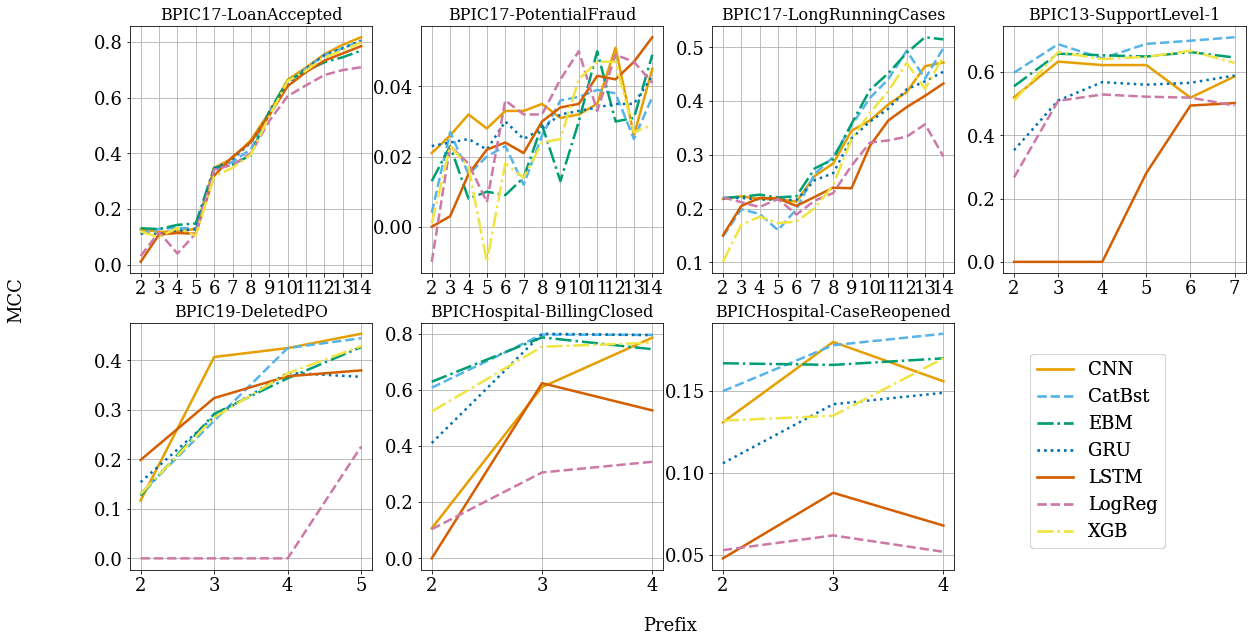

In [89]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
plt.rc("axes", prop_cycle=line_cycler)

for outcome, ax in zip(outcome_target_list,axs.flat):
    df = results[results['Outcome'] == outcome]
    event_lengths = df.Event_Length.unique()
        
    for key, model in df.groupby('Model'):
        model.plot(x='Event_Length', y='Mcc', ax=ax, xticks=event_lengths)
    ax.grid()   
    ax.set_xlabel("")
    ax.legend().set_visible(False)
    ax.set_title(outcome, fontdict={'fontsize':16})
    
    axs[1,3].set_axis_off()

    fig.legend(labels=labels, loc='center right', bbox_to_anchor=(0.85, 0.29))
    
fig.text(0.5, 0.04, 'Prefix', ha='center')
fig.text(0.04, 0.5, 'MCC', va='center', rotation='vertical')

plt.savefig('MCC_Subplots')

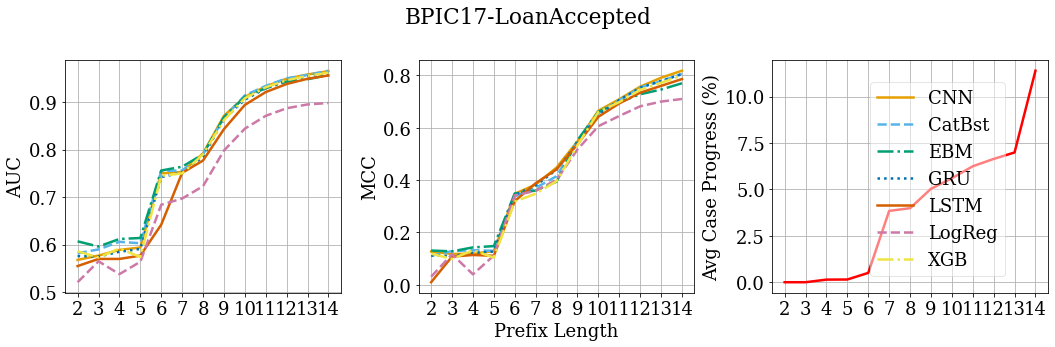

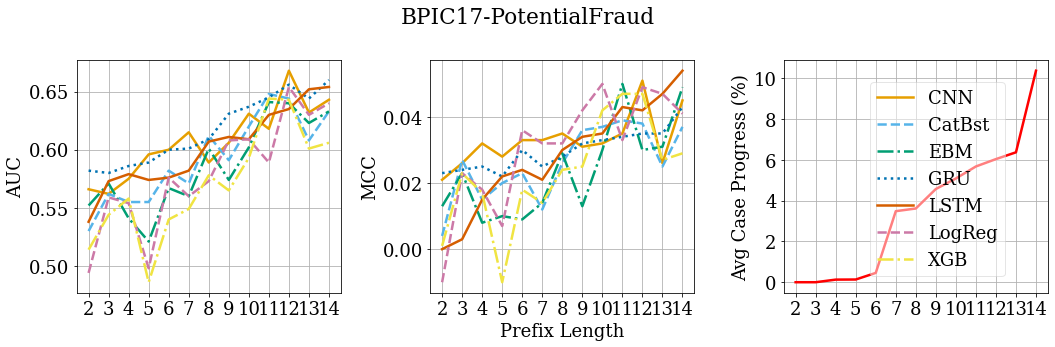

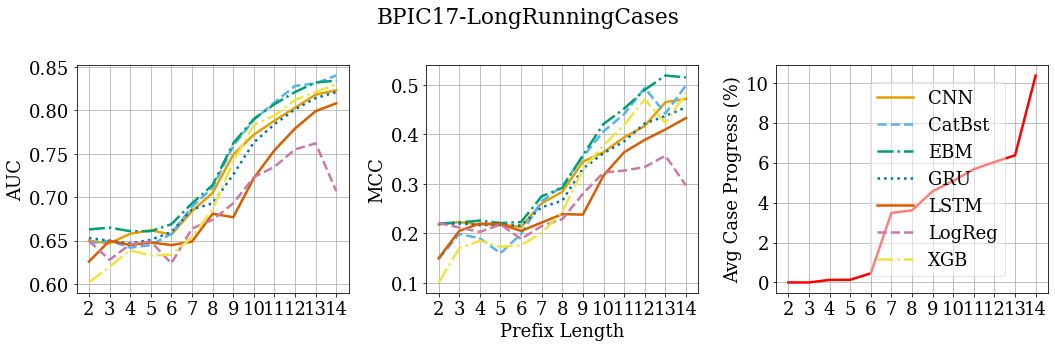

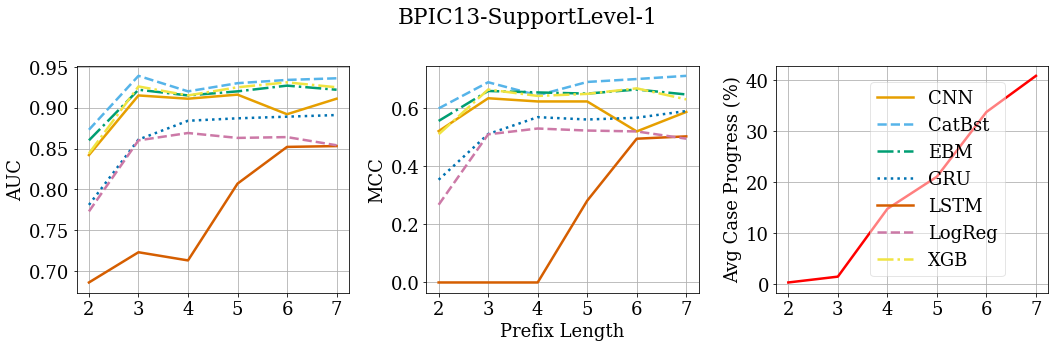

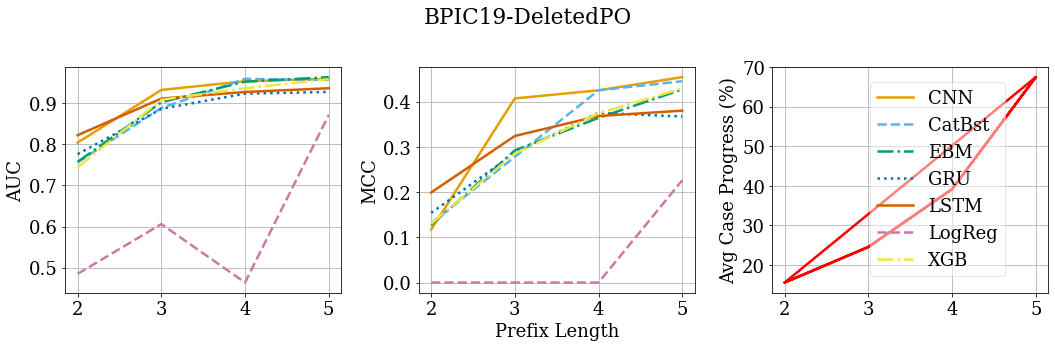

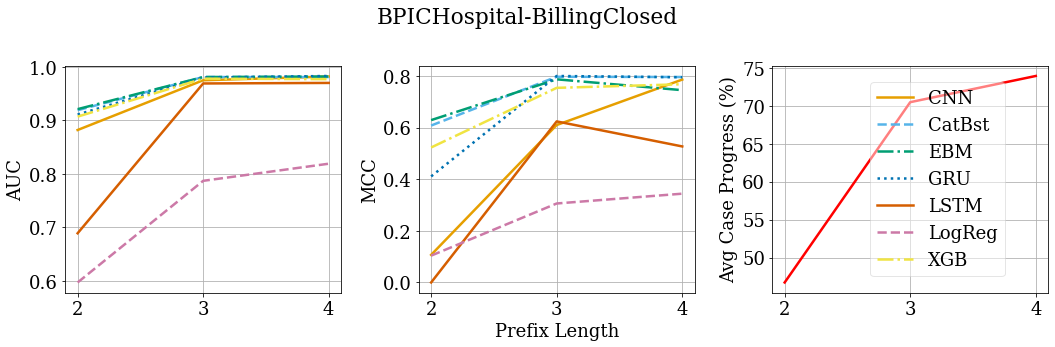

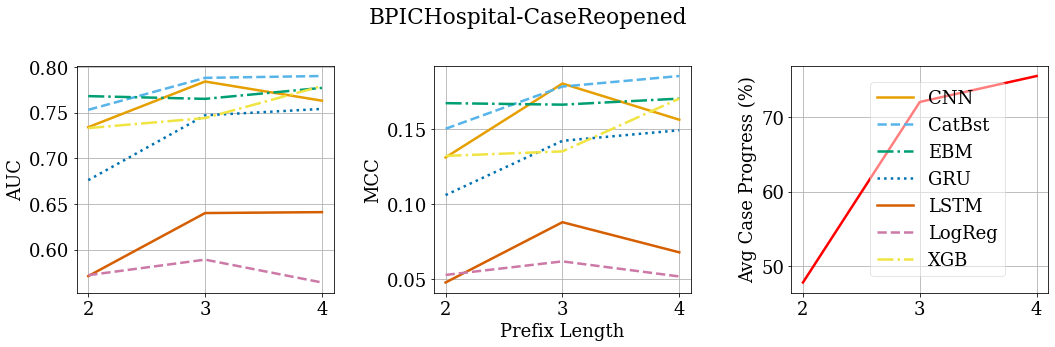

In [30]:
import numpy as np
x = np.linspace(0., 1., 200)


for outcome in outcome_target_list:
    df = results[results['Outcome'] == outcome]
    event_lengths = df.Event_Length.unique()
        
    plt.rc("axes", prop_cycle=line_cycler)
    #plt.tight_layout()
    fig = plt.figure(figsize=(15,5))


    fig.suptitle(outcome)

    ax1 = fig.add_subplot(131)
    ax1.set_ylabel("AUC")
    for key, model in df.groupby('Model'):
        model.plot(x='Event_Length', y='Auc', ax=ax1, xticks=event_lengths)
    ax1.grid()   
    ax1.set_xlabel("")
    ax1.legend().set_visible(False)

    ax2 = fig.add_subplot(132)
    ax2.set_ylabel("MCC")
    for key, model in df.groupby('Model'):
        model.plot(x='Event_Length', y='Mcc', ax=ax2, label=key, xticks=event_lengths)
    ax2.grid()   
    ax2.legend().set_visible(False)
    ax2.set_xlabel("Prefix Length")


    ax3 = fig.add_subplot(133)
    ax3.set_ylabel("Avg Case Progress (%)")
    df.plot(x='Event_Length', y='Avg_Case_Progress', ax=ax3, xticks=event_lengths, color='red')
    ax3.grid()    
    ax3.set_xlabel("")
    ax3.legend().set_visible(False)

    #fig.legend(ncol=7, labels=labels, loc='lower center', bbox_to_anchor=(0.5, -0.1))
    fig.legend(labels=labels, loc='center right', bbox_to_anchor=(0.95, 0.5)
              )
    plt.tight_layout()
    plt.savefig(outcome)
    
    #Export Results as csv
    result_table = df.groupby(['Model']).mean()
    result_table = result_table.drop(columns=['Event_Length', 'Avg_Case_Progress'])
    result_table.to_csv(outcome + "csv", sep=";")
    #result_table = result_table.to_latex(index=False)
    #file = open(outcome + '.txt', 'w')
    #file.write(result_table)
    #file.close() 

## Comparison of different categorical encoding methods (EBM and CatBoost)

In [94]:
%%time

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from catboost import CatBoostClassifier
from interpret.glassbox import ExplainableBoostingClassifier
import time


clfs = []
clfs.append(CatBoostClassifier(silent=True)) 

results = pd.DataFrame()

for outcome in outcome_target_list:
    print(outcome)
    eventlog = outcome.split('-')[0]
        
    #Load and label Dataset 
    data, case_id_col, activity_col, timestamp_col, label_col, resource_col, event_categorical_attributes, event_numeric_attributes, case_categorical_attributes, case_numeric_attributes, static_cols, dynamic_cols, cat_cols = get_dataset_settings(eventlog)
    attributes = [event_categorical_attributes, case_categorical_attributes, event_numeric_attributes, case_numeric_attributes]
    data_labeled, drop_events_list, dl_attributes = define_binary_outcome_label(data, attributes, outcome_label=outcome)
    
    #Set Sequence Encoding Setting for ML Classifiers
    sequence_encoding_setting = dict(case_id_col=case_id_col, 
                          activity_col=activity_col,
                          label_col=label_col,
                          case_numeric_attributes=dl_attributes[3],
                          case_categorical_attributes=dl_attributes[1],
                          event_numeric_attributes=dl_attributes[2],
                          event_categorical_attributes=dl_attributes[0],
                            d_event_sequence = False,
                            d_event = True,
                            d_event_categorical = True,
                            d_case_categorical =True,
                            one_hot_case_categorical = False,   
                            d_event_numeric = True,
                            d_case_numeric = True)

    
    #Set max prefix length for benchmark depending on the dataset
    tmp = data[[case_id_col, 'event_nr']].groupby([case_id_col]).max()
    event_length_mean = int(tmp['event_nr'].mean())

    if event_length_mean <= 15:
        event_lengths = list(range(2,event_length_mean,1))
    else:
        event_lengths = list(range(2,15,1))
    
    
    #Run Model Training and Preprocessing for all classifers for each prefix length
    for event_length in event_lengths:
        print("\n ------- PREDICTION OF TRACES WITH LENGTH:", event_length, "-------")
        data_labeled_grouped = group_infrequent_features(data_labeled, max_category_levels = 15)
        trace_bucket, avg_case_progress = create_trace_bucket(data_labeled_grouped, event_length, get_case_progress=True)
        trace_bucket = remove_features(trace_bucket, dl_attributes[0], dl_attributes[1], dl_attributes[2], dl_attributes[3])
        trace_bucket = remove_events(data_labeled, trace_bucket, drop_events_list)

        train_raw, test_raw = split_data_temporal(data=trace_bucket, train_ratio=0.8)

        #ML Section
        ## Preprocessing
        train = aggregate_data(train_raw, 
                               **sequence_encoding_setting)

        test = aggregate_data(test_raw, 
                              **sequence_encoding_setting)

        train, test = replace_missing_cols(train, test)
        
        #Regex required for XGB and BPIC19
        regex = re.compile(r"\[|\]|<", re.IGNORECASE)
        train.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in train.columns.values]
        test.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in test.columns.values]
        
        X_train_ml, y_train_ml, X_test_ml, y_test_ml = prepare_ml_train_test(train,test, balanced)

        ## ML Model Training and Evaluation
        for clf in clfs:
            try:
                print("\n---", str(clf)[:7], "---", sep="")

                categorical_features_indices = np.where(X_train_ml.dtypes != np.float)[0]
                
                start_time = time.time()
                clf.fit(X_train_ml, y_train_ml, cat_features = categorical_features_indices)
                train_time = time.time() - start_time
                y_pred, auc, acc, f1, mcc, sensitivity, specificity, pred_time = get_evaluation_metrics(clf, X_test_ml, y_test_ml, X_train_ml, y_train_ml, exec_time=True)

                results = results.append(pd.DataFrame({
                                                  'Outcome':[outcome],
                                                  'Model':str(clf)[:7],
                                                  'Event_Length': [event_length], 
                                                  'Acc':[acc], 'Auc':[auc], 'F1':[f1],'Mcc':[mcc],
                                                  'Sensitivity':[sensitivity],'Specificity':[specificity],
                                                  'Train_Time':[train_time],
                                                  'Prediction_Time':[pred_time],
                                                  'Avg_Case_Progress':[avg_case_progress]}))
            except Exception as e:
                print(e)

      
        print("\n--- EBM ---")
        clf_ebm = ExplainableBoostingClassifier()
        start_time = time.time()
        clf_ebm.fit(X_train_ml, y_train_ml)
        train_time = time.time() - start_time
        y_pred, auc, acc, f1, mcc, sensitivity, specificity, pred_time = get_evaluation_metrics(clf_ebm, X_test_ml, y_test_ml, X_train_ml, y_train_ml, exec_time=True)

        results = results.append(pd.DataFrame({
                                  'Outcome':[outcome],
                                  'Model':'EBM',
                                  'Event_Length': [event_length], 
                                  'Acc':[acc], 'Auc':[auc], 'F1':[f1],'Mcc':[mcc],
                                  'Sensitivity':[sensitivity],'Specificity':[specificity],
                                  'Train_Time':[train_time],
                                  'Prediction_Time':[pred_time],
                                  'Avg_Case_Progress':[avg_case_progress]}))


        
        results.reset_index(drop=True, inplace=True)
        results.to_csv("Benchmark_Test_Categorical.csv", index=False)

results.reset_index(drop=True, inplace=True)
#results



BPIC17-LoanAccepted
Categoric Event Attributes: 6 ['concept:name', 'org:resource', 'Action', 'lifecycle:transition', 'Accepted', 'Selected'] 

Numeric Event Attributes: 13 ['CreditScore', 'FirstWithdrawalAmount', 'MonthlyCost', 'NumberOfTerms', 'OfferedAmount', 'timesincelastevent', 'timesincecasestart', 'timesincemidnight', 'event_nr', 'month', 'weekday', 'hour', 'open_cases'] 

Categoric Case Attributes: 3 ['case:ApplicationType', 'case:LoanGoal', 'EventOrigin'] 

Numeric Case Attributes: 1 ['case:RequestedAmount'] 

Dataset Shape (1202267, 26)
Assigning class labels...
Set labels to 1 for Outcome: O_Accepted
label
0    18621
1    12792
Name: case:concept:name, dtype: int64

 ------- PREDICTION OF TRACES WITH LENGTH: 2 -------
Binning and Grouping infrequent factor levels to: Other_infrequent
Making predictions after 2 completed events
Making predictions at time after cases have started on average:  0.0 hours/ 0.0 days
Making predictions at time before cases have finished on average:

Making predictions after 7 completed events
Making predictions at time after cases have started on average:  18.3 hours/ 0.763 days
Making predictions at time before cases have finished on average:  458.4 hours/ 19.1 days

 Shape: (219891, 27)
Features removed:  3

 Events included:
['A_Create Application' 'A_Submitted' 'W_Handle leads'
 'W_Complete application' 'A_Concept' 'A_Accepted' 'O_Create Offer'
 'O_Created' 'W_Assess potential fraud' 'W_Shortened completion ']
[] []
Undersampling Train Data
(20546, 50) (6283, 50)

---<catboo---
Confusion Matrix:
[[3320  444]
 [1380 1139]]
              precision    recall  f1-score   support

           0       0.71      0.88      0.78      3764
           1       0.72      0.45      0.56      2519

    accuracy                           0.71      6283
   macro avg       0.71      0.67      0.67      6283
weighted avg       0.71      0.71      0.69      6283

Accuracy: 0.71 (Train: 0.719 )
AUC: 0.759
F1: 0.67
MCC: 0.377
Sensitivity :  0.882
Sp

Making predictions after 12 completed events
Making predictions at time after cases have started on average:  31.7 hours/ 1.319 days
Making predictions at time before cases have finished on average:  445.0 hours/ 18.5 days

 Shape: (376096, 27)
Features removed:  3

 Events included:
['A_Create Application' 'A_Submitted' 'W_Handle leads'
 'W_Complete application' 'A_Concept' 'A_Accepted' 'O_Create Offer'
 'O_Created' 'O_Sent (mail and online)' 'W_Call after offers' 'A_Complete'
 'O_Sent (online only)' 'W_Assess potential fraud' 'A_Cancelled'
 'W_Shortened completion ' 'A_Denied']
[] []
Undersampling Train Data
(20546, 56) (6283, 56)

---<catboo---
Confusion Matrix:
[[3427  337]
 [ 398 2121]]
              precision    recall  f1-score   support

           0       0.90      0.91      0.90      3764
           1       0.86      0.84      0.85      2519

    accuracy                           0.88      6283
   macro avg       0.88      0.88      0.88      6283
weighted avg       0.88    

Confusion Matrix:
[[2493 3734]
 [  25   50]]
              precision    recall  f1-score   support

           0       0.99      0.40      0.57      6227
           1       0.01      0.67      0.03        75

    accuracy                           0.40      6302
   macro avg       0.50      0.53      0.30      6302
weighted avg       0.98      0.40      0.56      6302

Accuracy: 0.404 (Train: 0.75 )
AUC: 0.566
F1: 0.298
MCC: 0.015
Sensitivity :  0.4
Specificity :  0.667

 ------- PREDICTION OF TRACES WITH LENGTH: 4 -------
Binning and Grouping infrequent factor levels to: Other_infrequent
Making predictions after 4 completed events
Making predictions at time after cases have started on average:  0.7 hours/ 0.028 days
Making predictions at time before cases have finished on average:  524.9 hours/ 21.9 days

 Shape: (126036, 26)
Features removed:  1

 Events included:
['A_Create Application' 'A_Submitted' 'W_Handle leads'
 'W_Complete application' 'A_Concept']
[] []
Undersampling Train D

Making predictions after 9 completed events
Making predictions at time after cases have started on average:  24.0 hours/ 1.0 days
Making predictions at time before cases have finished on average:  501.6 hours/ 20.9 days

 Shape: (283581, 26)
Features removed:  1

 Events included:
['A_Create Application' 'A_Submitted' 'W_Handle leads'
 'W_Complete application' 'A_Concept' 'A_Accepted' 'O_Create Offer'
 'O_Created' 'O_Sent (mail and online)' 'O_Sent (online only)'
 'O_Cancelled' 'A_Cancelled' 'W_Shortened completion ' 'A_Denied'
 'O_Refused']
['concept:name_O_Refused'] ['concept:name_O_Refused']
Undersampling Train Data
(456, 59) (6302, 59)

---<catboo---
Confusion Matrix:
[[5320  907]
 [  59   16]]
              precision    recall  f1-score   support

           0       0.99      0.85      0.92      6227
           1       0.02      0.21      0.03        75

    accuracy                           0.85      6302
   macro avg       0.50      0.53      0.47      6302
weighted avg       0

Making predictions after 14 completed events
Making predictions at time after cases have started on average:  54.5 hours/ 2.27 days
Making predictions at time before cases have finished on average:  471.1 hours/ 19.6 days

 Shape: (440991, 26)
Features removed:  1

 Events included:
['A_Create Application' 'A_Submitted' 'W_Handle leads'
 'W_Complete application' 'A_Concept' 'A_Accepted' 'O_Create Offer'
 'O_Created' 'O_Sent (mail and online)' 'W_Call after offers' 'A_Complete'
 'O_Cancelled' 'O_Sent (online only)' 'W_Validate application' 'A_Denied'
 'O_Refused' 'A_Cancelled' 'W_Shortened completion ']
[] []
Undersampling Train Data
(456, 65) (6302, 65)

---<catboo---
Confusion Matrix:
[[4034 2193]
 [  31   44]]
              precision    recall  f1-score   support

           0       0.99      0.65      0.78      6227
           1       0.02      0.59      0.04        75

    accuracy                           0.65      6302
   macro avg       0.51      0.62      0.41      6302
weight

Making predictions after 6 completed events
Making predictions at time after cases have started on average:  2.4 hours/ 0.1 days
Making predictions at time before cases have finished on average:  523.2 hours/ 21.8 days

 Shape: (189054, 26)
Features removed:  1

 Events included:
['A_Create Application' 'A_Submitted' 'W_Handle leads'
 'W_Complete application' 'A_Concept' 'A_Accepted' 'O_Create Offer'
 'W_Assess potential fraud']
[] []
Undersampling Train Data
(13728, 54) (6302, 54)

---<catboo---
Confusion Matrix:
[[1758 3034]
 [ 201 1309]]
              precision    recall  f1-score   support

           0       0.90      0.37      0.52      4792
           1       0.30      0.87      0.45      1510

    accuracy                           0.49      6302
   macro avg       0.60      0.62      0.48      6302
weighted avg       0.75      0.49      0.50      6302

Accuracy: 0.487 (Train: 0.662 )
AUC: 0.641
F1: 0.484
MCC: 0.216
Sensitivity :  0.367
Specificity :  0.867

--- EBM ---
Confusi

Making predictions after 11 completed events
Making predictions at time after cases have started on average:  29.8 hours/ 1.242 days
Making predictions at time before cases have finished on average:  495.8 hours/ 20.7 days

 Shape: (346581, 26)
Features removed:  1

 Events included:
['A_Create Application' 'A_Submitted' 'W_Handle leads'
 'W_Complete application' 'A_Concept' 'A_Accepted' 'O_Create Offer'
 'O_Created' 'O_Sent (mail and online)' 'W_Call after offers'
 'O_Cancelled' 'O_Sent (online only)' 'W_Assess potential fraud'
 'A_Cancelled' 'W_Shortened completion ' 'A_Denied' 'O_Refused']
[] []
Undersampling Train Data
(13728, 63) (6302, 63)

---<catboo---
Confusion Matrix:
[[3369 1423]
 [ 289 1221]]
              precision    recall  f1-score   support

           0       0.92      0.70      0.80      4792
           1       0.46      0.81      0.59      1510

    accuracy                           0.73      6302
   macro avg       0.69      0.76      0.69      6302
weighted avg  

Confusion Matrix:
[[318 144]
 [155 894]]
              precision    recall  f1-score   support

           0       0.67      0.69      0.68       462
           1       0.86      0.85      0.86      1049

    accuracy                           0.80      1511
   macro avg       0.77      0.77      0.77      1511
weighted avg       0.80      0.80      0.80      1511

Accuracy: 0.802 (Train: 0.817 )
AUC: 0.856
F1: 0.768
MCC: 0.537
Sensitivity :  0.688
Specificity :  0.852

 ------- PREDICTION OF TRACES WITH LENGTH: 3 -------
Binning and Grouping infrequent factor levels to: Other_infrequent
Making predictions after 3 completed events
Making predictions at time after cases have started on average:  4.1 hours/ 0.173 days
Making predictions at time before cases have finished on average:  285.8 hours/ 11.9 days

 Shape: (22650, 21)
Features removed:  3

 Events included:
['Accepted' 'Queued' 'Completed']
[] []
Undersampling Train Data
(5092, 52) (1511, 52)

---<catboo---
Confusion Matrix:
[[4

label
0    242895
1      8839
Name: case:concept:name, dtype: int64

 ------- PREDICTION OF TRACES WITH LENGTH: 2 -------
Binning and Grouping infrequent factor levels to: Other_infrequent
Making predictions after 2 completed events
Making predictions at time after cases have started on average:  267.3 hours/ 11.138 days
Making predictions at time before cases have finished on average:  1449.3 hours/ 60.4 days

 Shape: (500633, 29)
Features removed:  2

 Events included:
['SRM: Created' 'SRM: Complete' 'Vendor creates invoice'
 'Vendor creates debit memo' 'SRM: Incomplete'
 'Create Purchase Order Item' 'Receive Order Confirmation'
 'Record Goods Receipt' 'Change Quantity' 'Change Price'
 'Block Purchase Order Item' 'Change Approval for Purchase Order'
 'Record Invoice Receipt' 'Record Service Entry Sheet'
 'Create Purchase Requisition Item' 'Change Delivery Indicator'
 'Cancel Goods Receipt' 'Change Storage Location' 'Change Currency'
 'Release Purchase Order' 'Change payment term'
 'U

['concept:name_Change Final Invoice Indicator', 'concept:name_Release Purchase Requisition'] ['concept:name_Change Final Invoice Indicator', 'concept:name_Release Purchase Requisition']
Undersampling Train Data
(14342, 98) (50347, 98)

---<catboo---
Confusion Matrix:
[[43982  4710]
 [  292  1363]]
              precision    recall  f1-score   support

           0       0.99      0.90      0.95     48692
           1       0.22      0.82      0.35      1655

    accuracy                           0.90     50347
   macro avg       0.61      0.86      0.65     50347
weighted avg       0.97      0.90      0.93     50347

Accuracy: 0.901 (Train: 0.995 )
AUC: 0.952
F1: 0.649
MCC: 0.398
Sensitivity :  0.903
Specificity :  0.824

--- EBM ---
Confusion Matrix:
[[48068   624]
 [  934   721]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     48692
           1       0.54      0.44      0.48      1655

    accuracy                           0.9

Confusion Matrix:
[[9346 5497]
 [ 202  460]]
              precision    recall  f1-score   support

           0       0.98      0.63      0.77     14843
           1       0.08      0.69      0.14       662

    accuracy                           0.63     15505
   macro avg       0.53      0.66      0.45     15505
weighted avg       0.94      0.63      0.74     15505

Accuracy: 0.632 (Train: 0.69 )
AUC: 0.734
F1: 0.453
MCC: 0.135
Sensitivity :  0.63
Specificity :  0.695

 ------- PREDICTION OF TRACES WITH LENGTH: 3 -------
Binning and Grouping infrequent factor levels to: Other_infrequent
Making predictions after 3 completed events
Making predictions at time after cases have started on average:  2775.6 hours/ 115.652 days
Making predictions at time before cases have finished on average:  1076.1 hours/ 44.8 days

 Shape: (224113, 32)
Features removed:  6

 Events included:
['NEW' 'FIN' 'RELEASE' 'CHANGE DIAGN' 'DELETE' 'BILLED' 'CHANGE END'
 'CODE OK' 'JOIN-PAT' 'SET STATUS' 'MANUAL' '

In [115]:
results_cat = pd.read_csv("Benchmark_Final_Test_Categorical.csv")
results_cat['Model'] = results_cat['Model'].replace(['<catboo'],'CatBst Categoric')
results_cat['Model'] = results_cat['Model'].replace(['EBM'],'EBM Categoric')
results_cat = results_cat.groupby(['Model']).mean()
results_cat = results_cat.drop(columns=['Event_Length', 'Avg_Case_Progress'])

results_num = pd.read_csv("Benchmark.csv")
results_num = results_num[(results_num['Model'] == 'EBM') | (results_num['Model'] == '<catboo')]
results_num['Model'] = results_num['Model'].replace(['<catboo'],'CatBst Numeric')
results_num['Model'] = results_num['Model'].replace(['EBM'],'EBM Numeric')
results_num = results_num.groupby(['Model']).mean()
results_num = results_num.drop(columns=['Event_Length', 'Avg_Case_Progress'])

results_exp = results_cat.append(results_num)
results_exp = results_exp.drop(columns=['F1'])
results_exp

results_exp = results_exp.round(decimals = 3)
results_exp.to_csv("Benchmark_Cat_Num.csv",sep=";")